In [1]:
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

# I- Training data

In [2]:
df = pd.read_excel('dataset_boucle_retour_to_use.xlsx')
del df['Unnamed: 0']
df = df[['id_mzml', 'id_molecule', 'source', 'retention_time_exp', 'retention_time', 'rt_diff', 
       'tic', 'mass_exp', 'mass', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40', 'root_similarity_20', 'root_similarity_40', 
       'cosine_similarity_isotopic_mod', 'num_isotopic_exp_peaks', 'num_isotopic_the_peaks', 
       'acquisition_mode', 'niveau_de_confiance']]
df['found_peaks_isotopic'] = df['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df['niveau_de_confiance_1'] = df['niveau_de_confiance'].map({'1': 1, '2A': 1, '2B': 1, '3': 1, '0': 0, 0:0, 1:1, 2:1, 3:1})

In [3]:
df[df['source']=='Agilent'][df.isna().any(axis=1)][df['acquisition_mode']=='Data independant'][df['niveau_de_confiance_1']==1]

,id_mzml,id_molecule,source,retention_time_exp,retention_time,rt_diff,tic,mass_exp,mass,cosine_similarity_20,...,scholle_similarity_40,root_similarity_20,root_similarity_40,cosine_similarity_isotopic_mod,num_isotopic_exp_peaks,num_isotopic_the_peaks,acquisition_mode,niveau_de_confiance,found_peaks_isotopic,niveau_de_confiance_1
3,1,353,Agilent,11.042650,NaN,NaN,9.317102e+05,222.088982,222.08921,0.565284,...,0.682398,0.699827,0.900468,0.999931,3,4,Data independant,2B,1,1
5,1,414,Agilent,12.881333,NaN,NaN,1.159173e+06,266.164954,266.16470,0.832422,...,0.923043,0.805640,0.808373,0.999518,3,4,Data independant,3,1,1
6,1,483,Agilent,12.367017,NaN,NaN,5.333661e+05,213.118659,213.11873,0.763475,...,0.243924,0.931362,0.606069,0.999770,4,4,Data independant,2,1,1
7,1,654,Agilent,3.533600,NaN,NaN,9.747127e+04,126.065332,126.06539,0.970775,...,0.922256,0.937723,0.784520,0.999721,2,3,Data independant,3,1,1
8,1,668,Agilent,9.139667,NaN,NaN,1.904979e+05,182.070840,182.07080,0.845356,...,0.875011,0.881638,0.878377,0.989002,2,3,Data independant,2B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,85,504,Agilent,4.122417,NaN,NaN,4.975584e+04,184.012529,184.01202,0.960403,...,0.090957,0.984041,0.432193,0.999508,3,3,Data independant,3,1,1
1244,85,539,Agilent,12.570150,NaN,NaN,2.816926e+06,206.168752,206.16707,0.957821,...,0.073751,0.847913,0.406779,0.999945,3,3,Data independant,3,1,1
1245,85,702,Agilent,7.491200,NaN,NaN,7.170086e+05,119.048780,119.04835,0.993947,...,0.983210,0.984874,0.942673,0.999725,3,3,Data independant,3,1,1
1246,85,740,Agilent,8.802767,NaN,NaN,2.197618e+05,282.061669,282.06161,0.994451,...,0.651467,0.978184,0.717214,0.999973,3,4,Data independant,2B,1,1


# II- Unseen data

In [4]:
df_final = pd.read_csv('final.csv')
df_join=df[['id_mzml','id_molecule','retention_time_exp', 'source', 'acquisition_mode']]
common = df_final.merge(df_join,on=['id_mzml','id_molecule','retention_time_exp'], how='left', indicator=True)
df_final_unseen = common[common._merge=='left_only']
df_final_unseen['found_peaks_isotopic'] = df_final_unseen['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)

In [5]:
print(len(df_final))
print(len(common))
print(len(df_final_unseen))
print(len(df_join))

79624
79624
77583
2462


# III- Allion, Agilent

In [233]:
df1 = df[(df['source']=='Agilent')&(df['acquisition_mode']=='Data independant')]
df_final_unseen = df_final_unseen[(df_final_unseen['source']=='Agilent')&(df_final_unseen['acquisition_mode']=='Data independant')]
# def sampling_k_elements(group, k=460):
#     if len(group) < k:
#         return group
#     return group.sample(k)

# df1 = df1.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

In [7]:
df1[(df1.niveau_de_confiance=='3')&(df1.cosine_similarity_isotopic_mod>0.99)].sample(5)

,id_mzml,id_molecule,source,retention_time_exp,retention_time,rt_diff,tic,mass_exp,mass,cosine_similarity_20,...,scholle_similarity_40,root_similarity_20,root_similarity_40,cosine_similarity_isotopic_mod,num_isotopic_exp_peaks,num_isotopic_the_peaks,acquisition_mode,niveau_de_confiance,found_peaks_isotopic,niveau_de_confiance_1
580,34,701,Agilent,8.946767,NaN,NaN,2.698559e+05,194.080317,194.08038,0.963741,...,0.625070,0.884099,0.771705,0.996271,2,3,Data independant,3,1,1
438,28,741,Agilent,8.866717,NaN,NaN,1.848843e+04,282.060454,282.06161,0.978174,...,0.877332,0.968614,0.639021,0.995290,2,4,Data independant,3,1,1
517,32,654,Agilent,3.596250,NaN,NaN,1.049179e+05,126.065669,126.06539,0.942342,...,0.923316,0.929056,0.782667,0.999721,2,3,Data independant,3,1,1
1200,81,539,Agilent,12.571767,NaN,NaN,2.808082e+06,206.168848,206.16707,0.957769,...,0.065076,0.841772,0.366339,0.999982,3,3,Data independant,3,1,1
1245,85,702,Agilent,7.491200,NaN,NaN,7.170086e+05,119.048780,119.04835,0.993947,...,0.983210,0.984874,0.942673,0.999725,3,3,Data independant,3,1,1


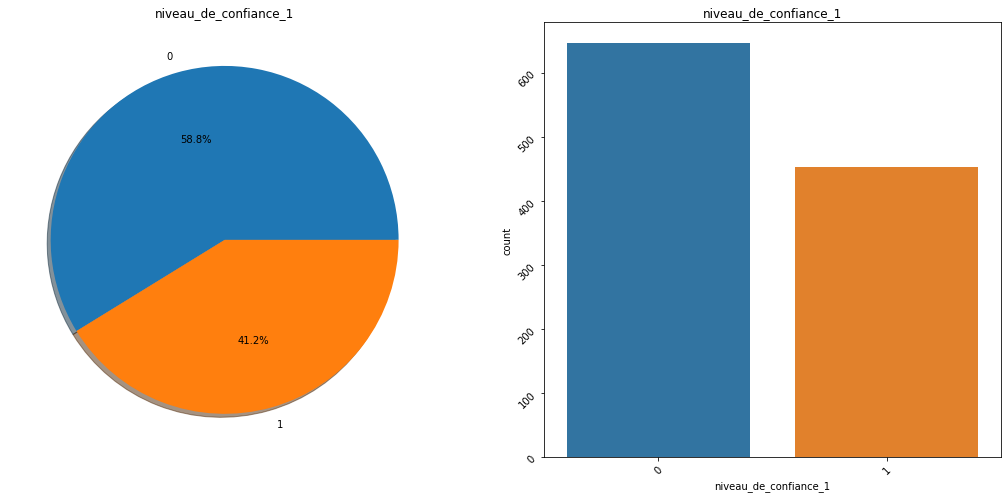

In [234]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [9]:
X1 = ['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

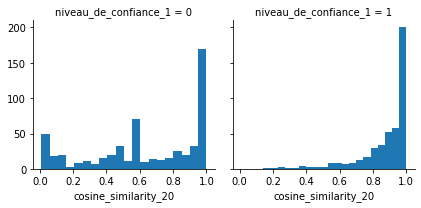

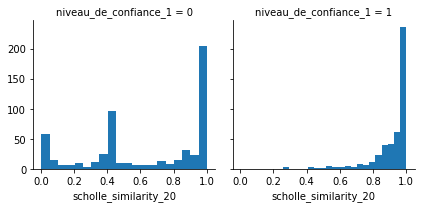

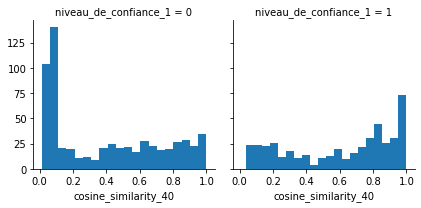

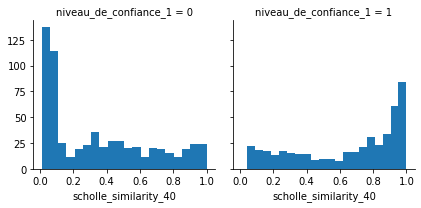

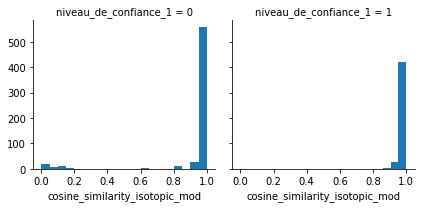

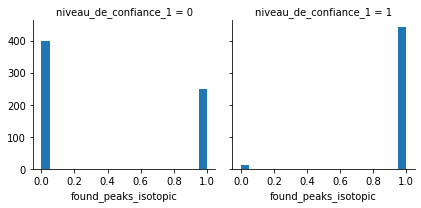

In [235]:
for i in X1:
    g = sns.FacetGrid(df1, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [236]:
X = df1[X1]

y = df1['niveau_de_confiance_1']

In [237]:
for c in X1:
    no_missing = df1[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
82
scholle_similarity_20
82
cosine_similarity_40
19
scholle_similarity_40
19
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [238]:
X = X.fillna(0)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [15]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [16]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [17]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [18]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [19]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [20]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [21]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [22]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [23]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.426662,0.067148,0.908971,0.907359,0.905840,0.908816,0.963709
6,K-Nearest Neighbors,0.008299,0.028015,0.889457,0.888764,0.884379,0.889102,0.938829
1,Decision Tree,0.012176,0.020513,0.884279,0.881988,0.879654,0.884016,0.879654
2,Support Vector Machine,0.045588,0.016978,0.877751,0.876404,0.871969,0.877343,0.928356
0,Logistic Regression,0.034693,0.019428,0.873855,0.872580,0.868180,0.873413,0.929881
3,Linear Discriminant Analysis,0.015039,0.018324,0.860868,0.860750,0.862144,0.861130,0.928196
7,Bayes,0.009901,0.022722,0.830930,0.834606,0.845040,0.832186,0.918291
4,Quadratic Discriminant Analysis,0.006589,0.013389,0.825701,0.829048,0.839616,0.827007,0.924199


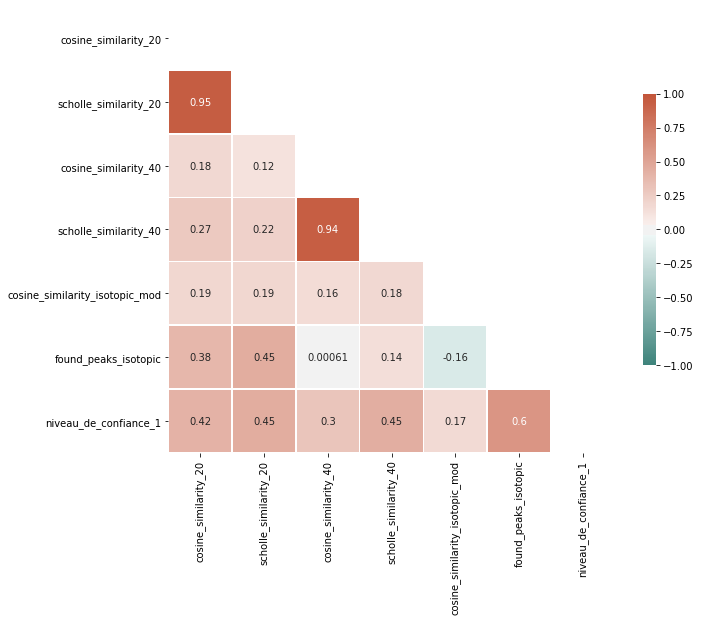

In [24]:
correlation = df1[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

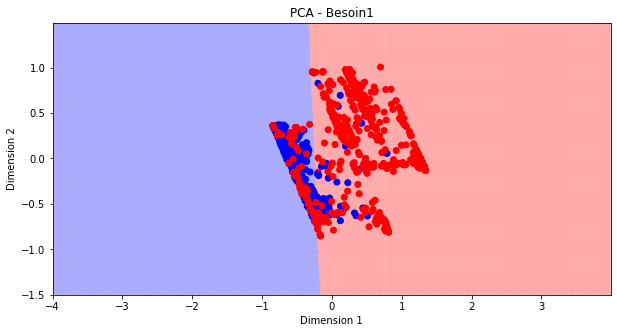

In [240]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,4
y_min, y_max = -1.5,1.5


X, y = X, y
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap=cmap_bold)
plt.show()

## 1- Random Forest

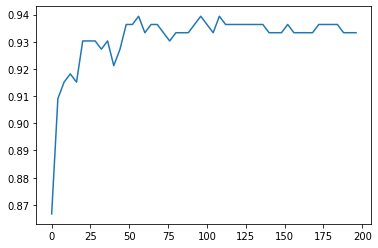

In [26]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train, y_train)  
    pred_y = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [27]:
RFC = RandomForestClassifier(random_state=7, n_estimators=50)
RFC.fit(X_train, y_train)  
pred_y = RFC.predict(X_test)
accuracy = metrics.accuracy_score(y_test, pred_y)
print(accuracy)

0.9363636363636364


In [28]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[178  10]
 [ 11 131]]

Normalized confusion matrix:
[0.94680851 0.05319149]
[0.07746479 0.92253521]


## 2- Decision tree

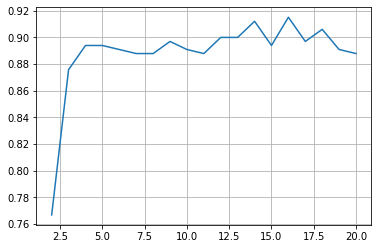

In [29]:
acc=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(X_train,y_train)
    prediction4=model.predict(X_test)
    acc.append(metrics.accuracy_score(prediction4,y_test))
plt.plot(range(2,21), acc)
plt.grid()

In [30]:
DTC4=DecisionTreeClassifier(max_leaf_nodes=4)
DTC4.fit(X_train,y_train)
prediction4=DTC4.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test))

The accuracy of the Decision Tree is 0.8939393939393939


In [31]:
X_train.columns

Index(['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic'],
      dtype='object')

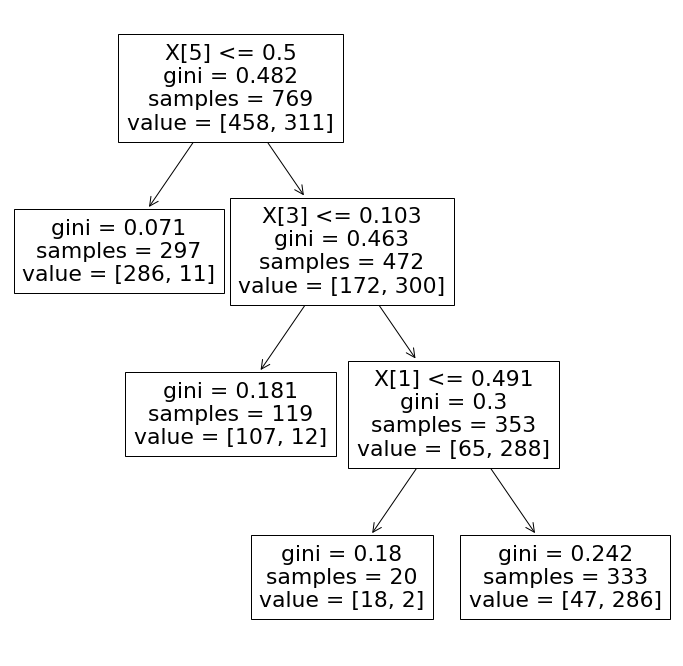

In [32]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC4)

In [33]:
DTC6=DecisionTreeClassifier(max_leaf_nodes=6)
DTC6.fit(X_train,y_train)
prediction4=DTC6.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test))

The accuracy of the Decision Tree is 0.8909090909090909


In [34]:
X_train.columns

Index(['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic'],
      dtype='object')

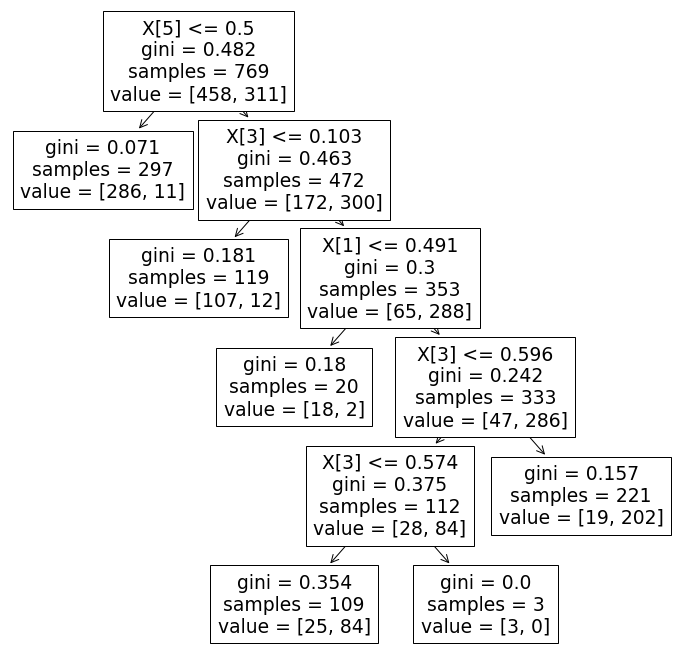

In [35]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC6)

## 3- test on unseen data

In [36]:
df_final = pd.read_csv('final.csv')
df_join=df[['id_mzml','id_molecule','retention_time_exp', 'source', 'acquisition_mode']]
common = df_final.merge(df_join,on=['id_mzml','id_molecule','retention_time_exp'], how='left', indicator=True)
df_final_unseen = common[common._merge=='left_only']
df_final_unseen['found_peaks_isotopic'] = df_final_unseen['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)

In [37]:
mzml16 = df_final_unseen[df_final_unseen['id_mzml']==16]
mzml16 = mzml16[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
mzml16 = mzml16.fillna(0)

In [38]:
mzml16

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic
7181,16,0,5.166783,0.226184,0.261830,0.674905,0.607767,0.113586,1
7182,16,0,7.275483,0.220475,0.142000,0.659583,0.538912,0.113586,1
7183,16,2,8.381283,0.069365,0.067368,0.180771,0.153593,0.989695,0
7184,16,2,8.947033,0.071067,0.065994,0.242672,0.227692,0.989695,0
7185,16,2,9.319900,0.068973,0.084613,0.170759,0.148981,0.989695,0
...,...,...,...,...,...,...,...,...,...
8660,16,1502,10.760067,0.224081,0.240922,0.365430,0.350530,0.962786,0
8661,16,1502,13.601683,0.097668,0.134902,0.172736,0.194806,0.962786,0
8662,16,1506,7.725517,0.083852,0.092197,0.395648,0.345703,0.983259,0
8663,16,1506,10.001450,0.063880,0.057616,0.447215,0.424787,0.983259,0


In [39]:
mzml16['predicted_class'] = RFC.predict(mzml16[X1])
mzml16['prob'] = RFC.predict_proba(mzml16[X1])[:,1:2]

In [40]:
mzml16[(mzml16['prob']>0.9)].sort_values(by=['prob'], ascending=True).sample(5)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob
7457,16,300,5.115350,0.909757,0.919314,0.823793,0.867762,0.999632,1,1,0.98
8156,16,788,7.815517,0.817606,0.863638,0.645574,0.630802,0.997830,1,1,0.94
7374,16,224,6.851183,0.915768,0.851659,0.661007,0.723661,0.995604,1,1,0.94
8148,16,782,10.978667,0.996378,0.996798,0.988400,0.991772,0.996987,1,1,0.96
8630,16,1445,14.848933,0.911792,0.953783,0.239403,0.429856,0.998631,1,1,0.92


## 4- Use scholle similarity

In [41]:
X2 = ['scholle_similarity_20', 'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

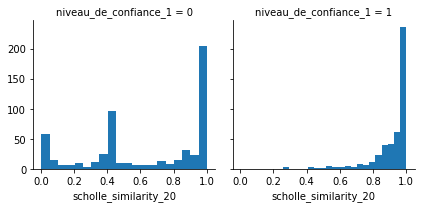

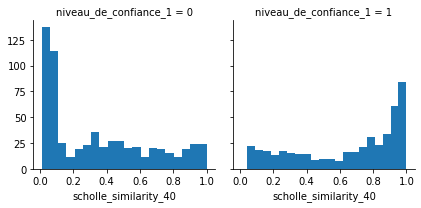

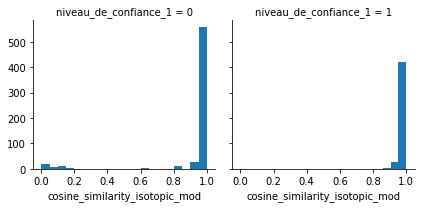

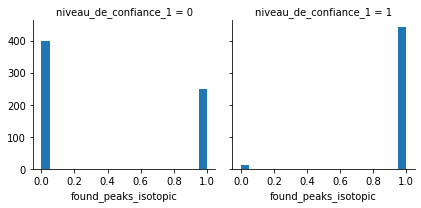

In [42]:
for i in X2:
    g = sns.FacetGrid(df1, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [43]:
X_scholle = df1[X2]

y_scholle = df1['niveau_de_confiance_1']

In [44]:
for c in X1:
    no_missing = df1[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
82
scholle_similarity_20
82
cosine_similarity_40
19
scholle_similarity_40
19
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [45]:
X_scholle = X_scholle.fillna(0)

In [46]:
X_train_scholle, X_test_scholle, y_train_scholle, y_test_scholle = train_test_split(X_scholle,y_scholle,test_size=0.3)

In [47]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [48]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [49]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [50]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [51]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [52]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [53]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [54]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_scholle, y_train_scholle, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [55]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.419472,0.074493,0.921958,0.920547,0.921490,0.922053,0.959696
6,K-Nearest Neighbors,0.009163,0.029425,0.886842,0.885151,0.885271,0.886910,0.926078
2,Support Vector Machine,0.057552,0.026794,0.881681,0.881211,0.876637,0.881342,0.925887
1,Decision Tree,0.008890,0.016546,0.877802,0.876543,0.873151,0.877393,0.873151
3,Linear Discriminant Analysis,0.019409,0.022130,0.877785,0.875294,0.878092,0.878011,0.928231
0,Logistic Regression,0.025413,0.016783,0.869959,0.869541,0.862849,0.869338,0.930580
7,Bayes,0.007836,0.017206,0.817943,0.828793,0.835843,0.818834,0.927115
4,Quadratic Discriminant Analysis,0.016152,0.022753,0.816627,0.827953,0.834732,0.817486,0.930678


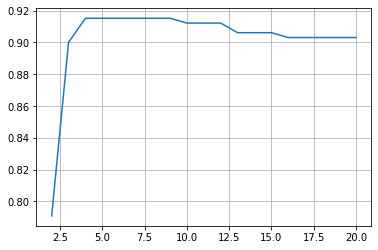

In [56]:
acc=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(X_train_scholle,y_train_scholle)
    prediction4=model.predict(X_test_scholle)
    acc.append(metrics.accuracy_score(prediction4,y_test_scholle))
plt.plot(range(2,21), acc)
plt.grid()

In [57]:
DTC7_scholle=DecisionTreeClassifier(max_leaf_nodes=7)
DTC7_scholle.fit(X_train_scholle,y_train_scholle)
prediction4=DTC7_scholle.predict(X_test_scholle)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test_scholle))

The accuracy of the Decision Tree is 0.9151515151515152


In [58]:
X_train_scholle.columns

Index(['scholle_similarity_20', 'scholle_similarity_40',
       'cosine_similarity_isotopic_mod', 'found_peaks_isotopic'],
      dtype='object')

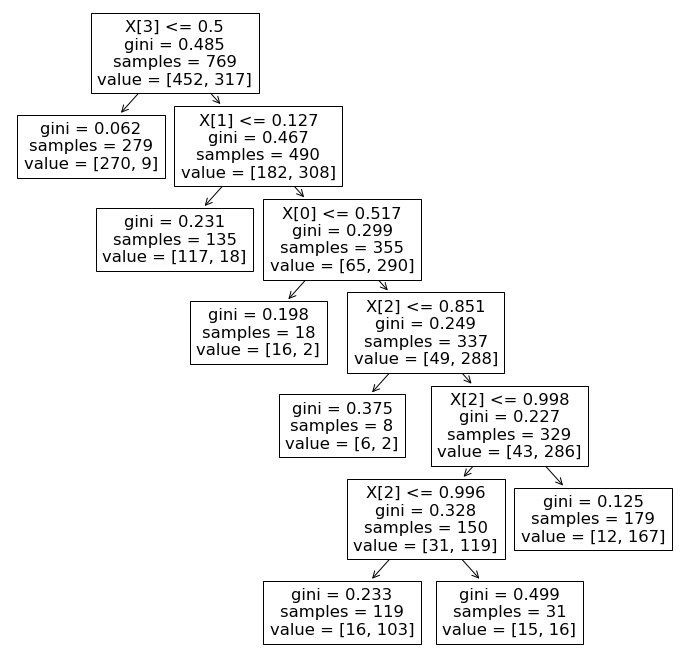

In [59]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC7_scholle)

## 5- Let one mzml to test on it

### 5.1- let mzml 16

In [241]:
df1_non16 = df[(df['source']=='Agilent')&(df['acquisition_mode']=='Data independant')&(df['id_mzml']!=16)]
df_final_16 = pd.read_csv('final.csv')
df_final_16 = df_final_16[df_final_16['id_mzml']==16]
def sampling_k_elements(group, k=420):
    if len(group) < k:
        return group
    return group.sample(k)

df1_non16 = df1_non16.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

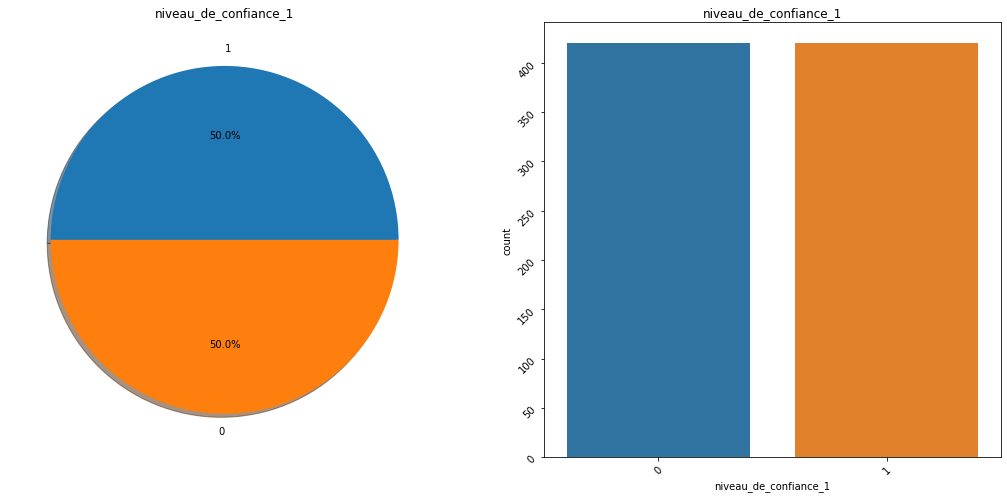

In [242]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1_non16[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1_non16,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [62]:
X1 = ['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

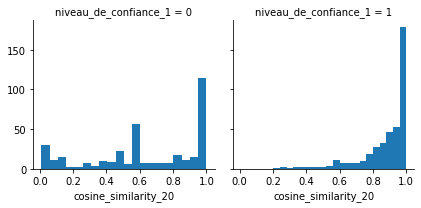

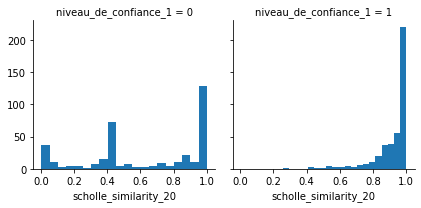

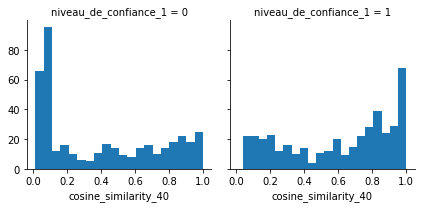

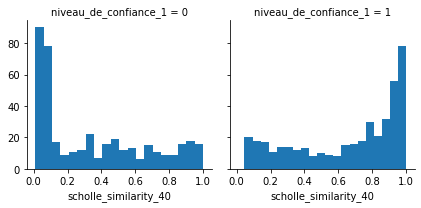

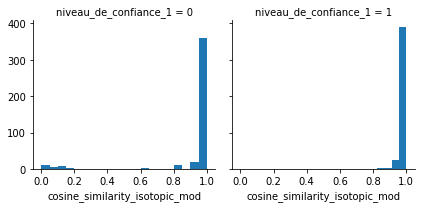

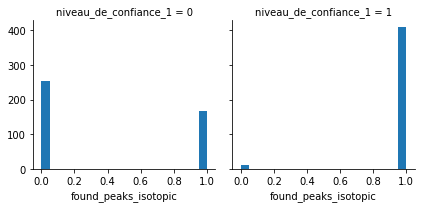

In [243]:
for i in X1:
    g = sns.FacetGrid(df1_non16, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [244]:
X_non16 = df1_non16[X1]

y_non16 = df1_non16['niveau_de_confiance_1']

In [245]:
for c in X1:
    no_missing = df1_non16[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
56
scholle_similarity_20
56
cosine_similarity_40
14
scholle_similarity_40
14
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [246]:
X_non16 = X_non16.fillna(0)

In [247]:
X_train_non16, X_test_non16, y_train_non16, y_test_non16 = train_test_split(X_non16,y_non16,test_size=0.3)

In [68]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [69]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [70]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [71]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [72]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [73]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [74]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [75]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_non16, y_train_non16, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [76]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.481359,0.071042,0.908153,0.911602,0.907902,0.907917,0.960023
6,K-Nearest Neighbors,0.013676,0.041081,0.896347,0.898235,0.896654,0.896207,0.939409
2,Support Vector Machine,0.043425,0.024863,0.879427,0.882532,0.879068,0.879124,0.937032
1,Decision Tree,0.014127,0.022994,0.870807,0.874995,0.870427,0.870416,0.870427
0,Logistic Regression,0.082200,0.026909,0.858825,0.867682,0.860094,0.857752,0.936293
3,Linear Discriminant Analysis,0.009988,0.018863,0.847019,0.860708,0.848904,0.845373,0.936958
4,Quadratic Discriminant Analysis,0.009417,0.020609,0.841847,0.857862,0.843596,0.839908,0.941626
7,Bayes,0.012805,0.029544,0.840123,0.856557,0.841868,0.838095,0.925472


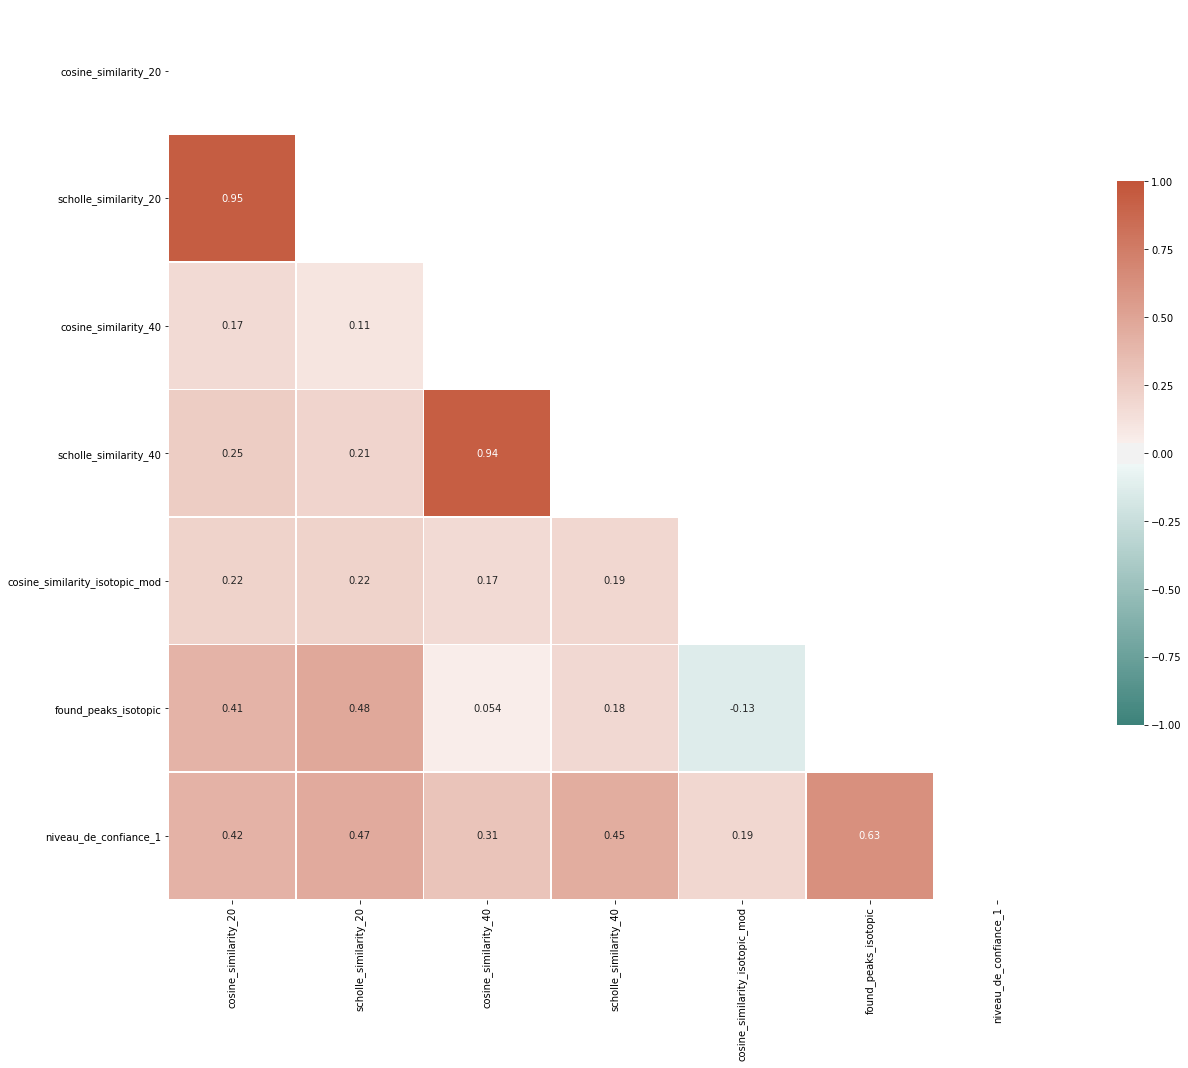

In [77]:
correlation = df1_non16[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

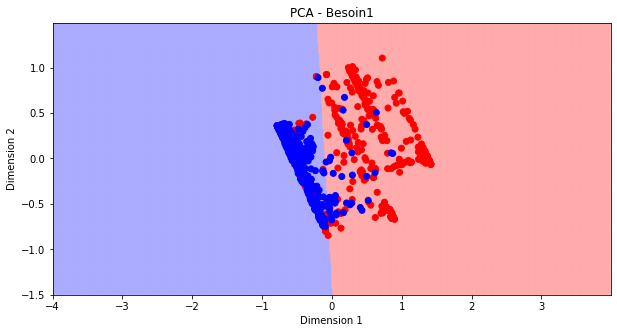

In [248]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,4
y_min, y_max = -1.5,1.5


X_non16, y_non16 = X_non16, y_non16
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X_non16)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y_non16)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_non16,cmap=cmap_bold)
plt.show()

## 1- Random Forest

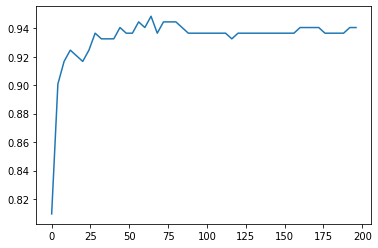

In [79]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train_non16, y_train_non16)  
    pred_y = model.predict(X_test_non16)
    accuracy = metrics.accuracy_score(y_test_non16, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [80]:
RFC_non16 = RandomForestClassifier(random_state=7, n_estimators=50)
RFC_non16.fit(X_train_non16, y_train_non16)  
pred_y = RFC_non16.predict(X_test_non16)
accuracy = metrics.accuracy_score(y_test_non16, pred_y)
print(accuracy)

0.9365079365079365


In [81]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non16, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[116   4]
 [ 12 120]]

Normalized confusion matrix:
[0.96666667 0.03333333]
[0.09090909 0.90909091]


In [250]:
LR_non16 = LogisticRegression(random_state=7)
LR_non16.fit(X_train_non16, y_train_non16)  
pred_y = LR_non16.predict(X_test_non16)
accuracy = metrics.accuracy_score(y_test_non16, pred_y)
print(accuracy)

0.9087301587301587


In [251]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non16, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[119   8]
 [ 15 110]]

Normalized confusion matrix:
[0.93700787 0.06299213]
[0.12 0.88]


In [252]:
df_final_16 = pd.read_csv('final.csv')
df_final_16 = df_final_16[df_final_16['id_mzml']==16]
df_final_16['found_peaks_isotopic'] = df_final_16['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_16 = df_final_16[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_16 = df_final_16.fillna(0)
df_final_16['predicted_class'] = LR_non16.predict(df_final_16[X1])
df_final_16['prob'] = LR_non16.predict_proba(df_final_16[X1])[:,1:2]

In [255]:
df_final_16[(df_final_16['prob']>0.7)&(df_final_16['prob']<=0.8)].sort_values(by=['prob'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob
8625,16,1442,11.518700,0.568460,0.414306,0.901398,0.918446,0.992530,1,1,0.792166
8156,16,788,7.815517,0.817606,0.863638,0.645574,0.630802,0.997830,1,1,0.786299
8338,16,1027,14.578917,0.794910,0.938254,0.400645,0.581202,0.999508,1,1,0.783725
7944,16,634,3.842417,0.766366,0.717103,0.702243,0.706760,0.996293,1,1,0.782396
8004,16,680,4.356733,0.603993,0.664734,0.788187,0.762942,0.995956,1,1,0.781649
7759,16,498,8.329850,0.945854,0.976935,0.471550,0.528195,0.997525,1,1,0.777218
7773,16,512,0.885017,0.602639,0.711605,0.658065,0.725239,0.993677,1,1,0.776277
8200,16,833,7.352633,0.913185,0.941763,0.608726,0.544987,0.986902,1,1,0.767776
7853,16,573,14.848933,0.798359,0.825658,0.564997,0.610589,0.994369,1,1,0.765088
7603,16,392,8.767017,0.443836,0.410419,0.711885,0.906381,0.942241,1,1,0.764994


In [82]:
df_final_16 = pd.read_csv('final.csv')
df_final_16 = df_final_16[df_final_16['id_mzml']==16]
df_final_16['found_peaks_isotopic'] = df_final_16['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_16 = df_final_16[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_16 = df_final_16.fillna(0)
df_final_16['predicted_class'] = RFC_non16.predict(df_final_16[X1])
df_final_16['prob'] = RFC_non16.predict_proba(df_final_16[X1])[:,1:2]

In [83]:
df_final_16[(df_final_16['prob']>=0.7)&(df_final_16['prob']<0.76)].sort_values(by=['prob'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob
8567,16,1357,10.027167,0.564656,0.587256,0.720155,0.735306,0.992426,1,1,0.74
7694,16,444,8.419850,0.885692,0.849765,0.700736,0.738101,0.038798,1,1,0.74
7816,16,550,10.310050,0.997710,0.997330,0.796941,0.917087,0.995736,1,1,0.74
7852,16,573,14.373200,0.771802,0.541361,0.683024,0.712429,0.994369,1,1,0.74
8461,16,1175,10.374333,0.913647,0.995186,0.314909,0.357326,0.992057,1,1,0.74
7909,16,604,7.905533,0.417046,0.690481,0.314144,0.281900,0.996093,1,1,0.74
8141,16,779,8.419850,0.845427,0.797883,0.762943,0.775758,0.038798,1,1,0.74
7861,16,573,18.037717,0.688051,0.742098,0.582655,0.585062,0.782099,1,1,0.72
8623,16,1439,13.434533,0.959058,0.989139,0.214147,0.307855,0.987505,1,1,0.72
7600,16,389,9.281333,0.779346,0.578922,0.639330,0.562082,0.992908,1,1,0.72


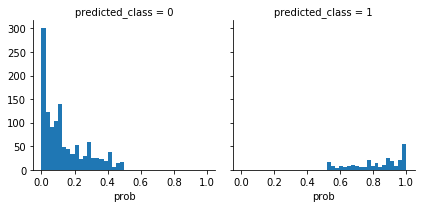

In [84]:
g = sns.FacetGrid(df_final_16, col='predicted_class')
g.map(plt.hist, 'prob', bins=20)

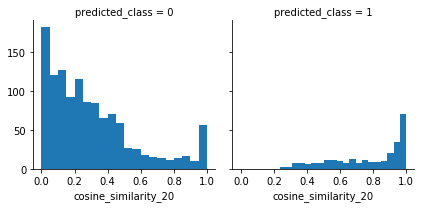

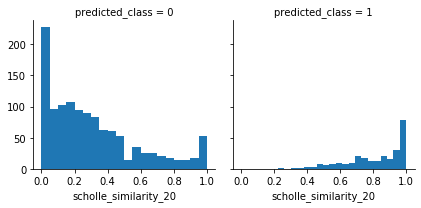

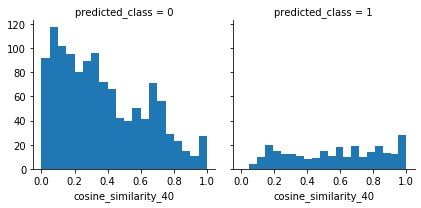

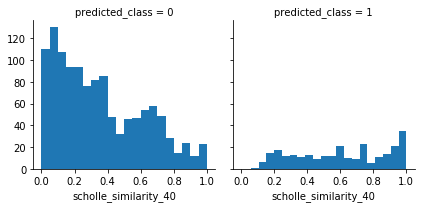

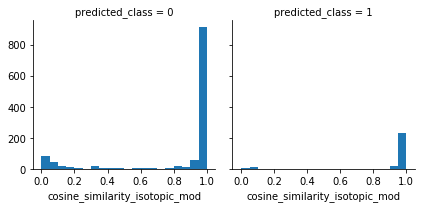

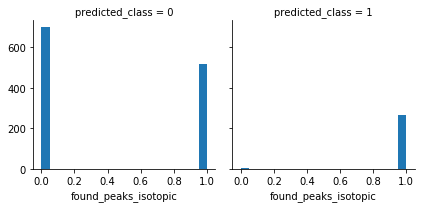

In [85]:
for i in X1:
    g = sns.FacetGrid(df_final_16, col='predicted_class')
    g.map(plt.hist, i, bins=20)

### 5.2- let mzml 18

In [86]:
df1_non18 = df[(df['source']=='Agilent')&(df['acquisition_mode']=='Data independant')&(df['id_mzml']!=18)]
df_final_18 = pd.read_csv('final.csv')
df_final_18 = df_final_18[df_final_18['id_mzml']==18]
def sampling_k_elements(group, k=420):
    if len(group) < k:
        return group
    return group.sample(k)

df1_non18 = df1_non18.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

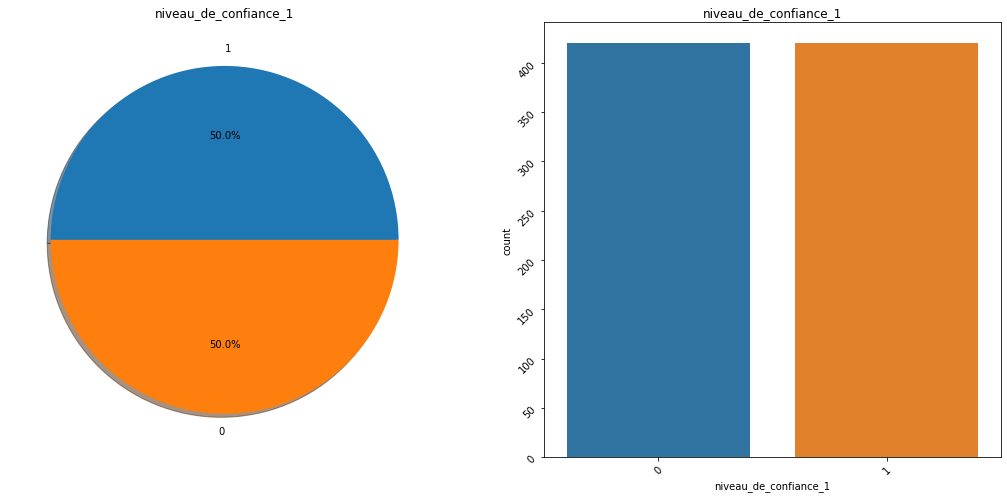

In [87]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1_non18[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1_non18,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [88]:
X1 = ['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

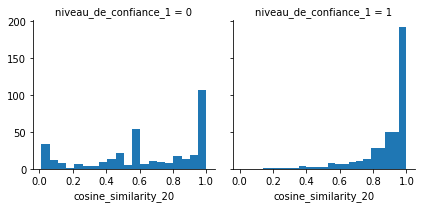

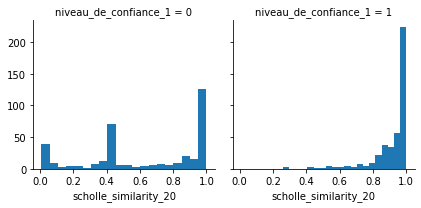

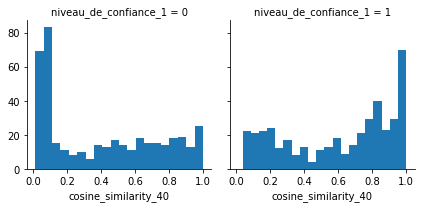

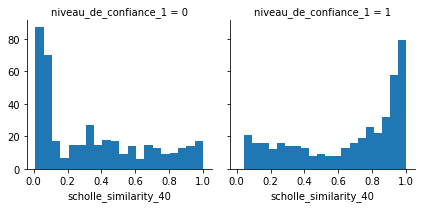

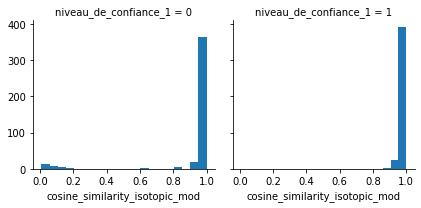

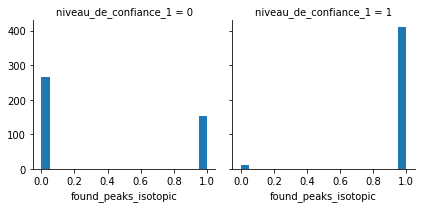

In [89]:
for i in X1:
    g = sns.FacetGrid(df1_non18, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [90]:
X_non18 = df1_non18[X1]

y_non18 = df1_non18['niveau_de_confiance_1']

In [91]:
for c in X1:
    no_missing = df1_non18[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
58
scholle_similarity_20
58
cosine_similarity_40
12
scholle_similarity_40
12
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [92]:
X_non18 = X_non18.fillna(0)

In [93]:
X_train_non18, X_test_non18, y_train_non18, y_test_non18 = train_test_split(X_non18,y_non18,test_size=0.3)

In [94]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [95]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [96]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [97]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [98]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [99]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [100]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [101]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_non18, y_train_non18, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [102]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.397023,0.058652,0.930187,0.933993,0.930230,0.929975,0.967045
6,K-Nearest Neighbors,0.008410,0.026026,0.891175,0.897307,0.891322,0.890782,0.940450
0,Logistic Regression,0.040248,0.020057,0.865693,0.879633,0.864770,0.863745,0.950384
1,Decision Tree,0.010500,0.021287,0.865488,0.869146,0.865690,0.865098,0.865690
4,Quadratic Discriminant Analysis,0.008924,0.020004,0.860579,0.874435,0.859713,0.858746,0.946120
7,Bayes,0.006650,0.017991,0.858913,0.871945,0.858103,0.857203,0.934744
3,Linear Discriminant Analysis,0.005990,0.015198,0.858854,0.877115,0.857644,0.856233,0.951070
2,Support Vector Machine,0.026291,0.011526,0.851958,0.868600,0.851034,0.849799,0.943060


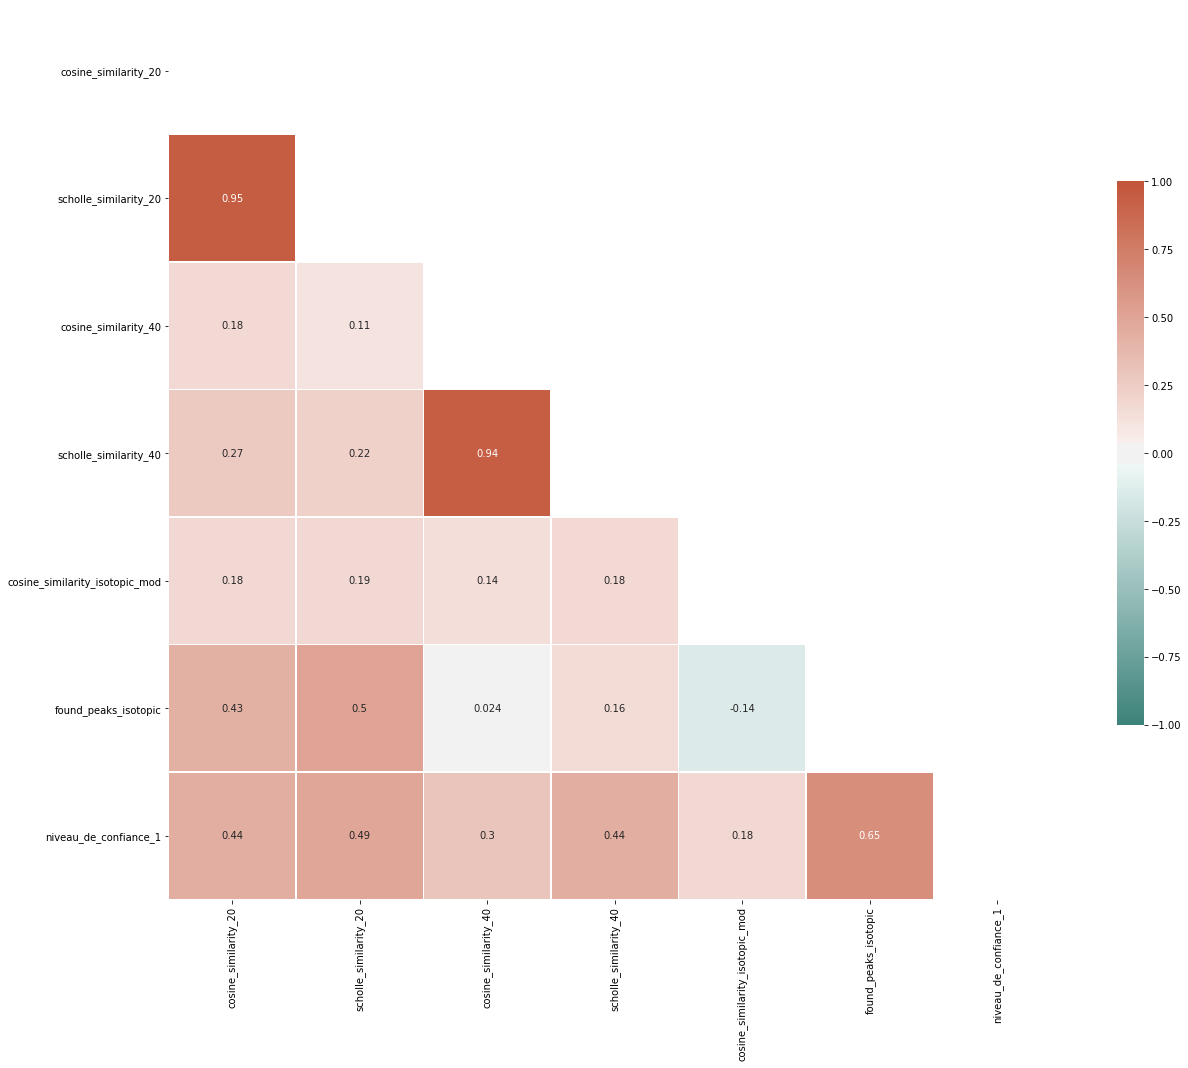

In [103]:
correlation = df1_non18[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

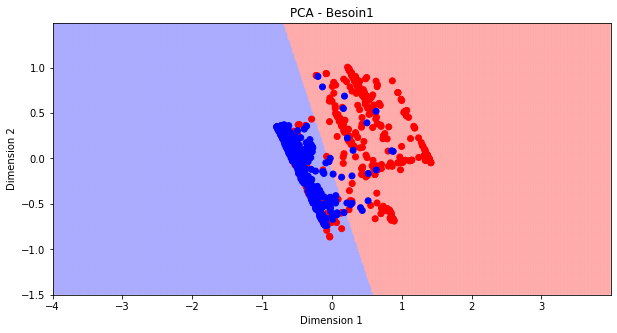

In [104]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,4
y_min, y_max = -1.5,1.5


X_non18, y_non18 = X_non18, y_non18
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X_non16)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = SVC(kernel='linear')
clf.fit(X_selected,y_non18)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_non18,cmap=cmap_bold)
plt.show()

## 1- Random Forest

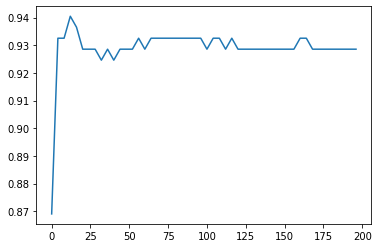

In [105]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train_non18, y_train_non18)  
    pred_y = model.predict(X_test_non18)
    accuracy = metrics.accuracy_score(y_test_non18, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [106]:
RFC_non18 = RandomForestClassifier(random_state=7, n_estimators=50)
RFC_non18.fit(X_train_non18, y_train_non18)  
pred_y = RFC_non18.predict(X_test_non18)
accuracy = metrics.accuracy_score(y_test_non18, pred_y)
print(accuracy)

0.9285714285714286


In [107]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non18, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[117  13]
 [  5 117]]

Normalized confusion matrix:
[0.9 0.1]
[0.04098361 0.95901639]


In [108]:
df_final_18 = pd.read_csv('final.csv')
df_final_18 = df_final_18[df_final_18['id_mzml']==18]
df_final_18['found_peaks_isotopic'] = df_final_18['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_18 = df_final_18[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_18 = df_final_18.fillna(0)
df_final_18['predicted_class'] = RFC_non18.predict(df_final_18[X1])
df_final_18['prob'] = RFC_non18.predict_proba(df_final_18[X1])[:,1:2]

In [109]:
df_final_18[(df_final_18['prob']>0.9)&(df_final_18['prob']<=0.95)].sort_values(by=['prob'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob
9070,18,40,12.993917,0.603432,0.850733,0.245113,0.195449,0.998581,1,1,0.94
9630,18,549,10.820933,0.764966,0.739298,0.587598,0.605897,0.997168,1,1,0.94
10130,18,978,11.412400,0.921019,0.944804,0.999238,0.999405,0.999982,1,1,0.94
10125,18,966,11.232383,0.862647,0.916461,0.369427,0.808749,0.941261,1,1,0.94
9995,18,788,7.824900,0.769530,0.820934,0.639457,0.629701,0.997830,1,1,0.94
9838,18,680,8.506450,0.711207,0.768720,0.628083,0.598002,0.995956,1,1,0.94
9071,18,40,13.276833,0.589707,0.800774,0.289821,0.245045,0.990661,1,1,0.94
10312,18,1222,10.628067,0.915694,0.923543,0.130229,0.449235,0.999552,1,1,0.94
9304,18,330,6.963417,0.731806,0.824292,0.247542,0.176209,0.998744,1,1,0.94
9105,18,107,15.462683,0.736634,0.759937,0.737842,0.929478,0.998276,1,1,0.94


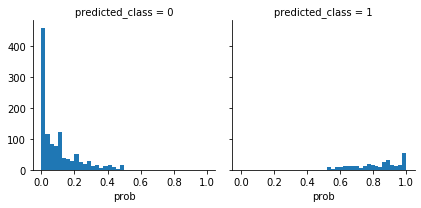

In [110]:
g = sns.FacetGrid(df_final_18, col='predicted_class')
g.map(plt.hist, 'prob', bins=20)

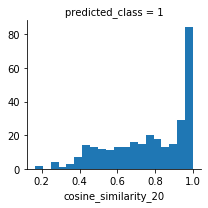

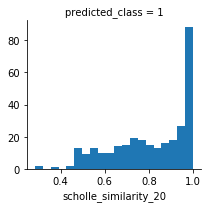

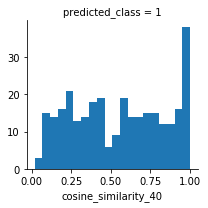

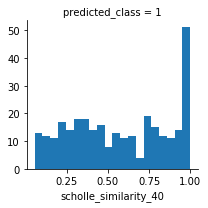

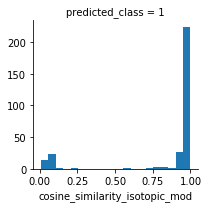

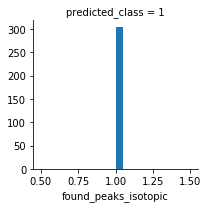

In [111]:
for i in X1:
    g = sns.FacetGrid(df_final_18[(df_final_18['prob']>0.5)&(df_final_18['prob']<=1)], col='predicted_class')
    g.map(plt.hist, i, bins=20)

# IV- Allion, INERIS

In [272]:
df1 = df[(df['source']=='INERIS')&(df['acquisition_mode']=='Data independant')]
df1['rt_diff_abs'] = df1['rt_diff'].apply(lambda x : abs(x))
df_final = pd.read_csv('final.csv')
df_join=df[['id_mzml','id_molecule','retention_time_exp', 'source', 'acquisition_mode']]
common = df_final.merge(df_join,on=['id_mzml','id_molecule','retention_time_exp'], how='left', indicator=True)
df_final_unseen = common[common._merge=='left_only']
df_final_unseen['found_peaks_isotopic'] = df_final_unseen['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_unseen = df_final_unseen[(df_final_unseen['source']=='INERIS')&(df_final_unseen['acquisition_mode']=='Data independant')]
def sampling_k_elements(group, k=370):
    if len(group) < k:
        return group
    return group.sample(k)

df1 = df1.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

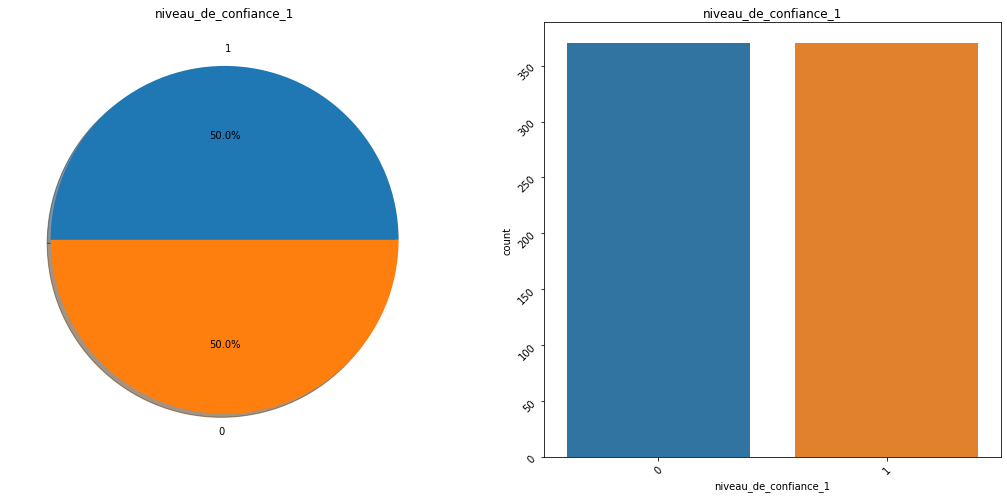

In [273]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [114]:
X1 = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

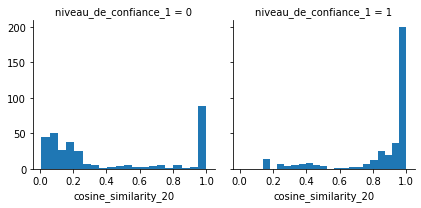

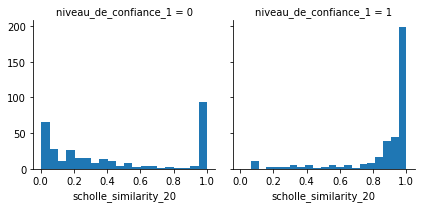

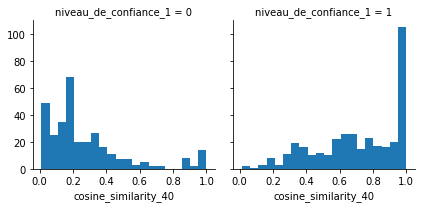

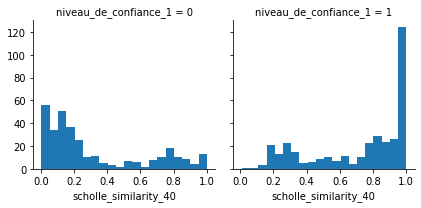

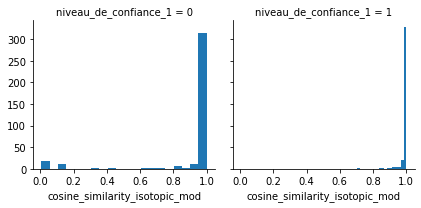

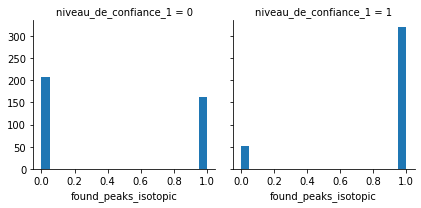

In [274]:
for i in X1:
    g = sns.FacetGrid(df1, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [275]:
X = df1[X1]

y = df1['niveau_de_confiance_1']

In [276]:
for c in X1:
    no_missing = df1[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
58
scholle_similarity_20
58
cosine_similarity_40
54
scholle_similarity_40
54
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [277]:
X = X.fillna(0)

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [279]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [280]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [281]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [282]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [283]:
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

In [284]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [285]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [286]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [287]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
5,Random Forest,0.393482,0.063729,0.918816,0.922045,0.918521,0.918663,0.970529
1,Decision Tree,0.008990,0.020479,0.903507,0.907695,0.903570,0.903280,0.903570
6,K-Nearest Neighbors,0.007863,0.024821,0.887971,0.890286,0.887724,0.887800,0.951571
2,Support Vector Machine,0.032309,0.019588,0.870701,0.874546,0.870179,0.870089,0.936708
3,Linear Discriminant Analysis,0.011209,0.021401,0.862971,0.867321,0.862712,0.862513,0.926609
4,Quadratic Discriminant Analysis,0.007334,0.013370,0.843741,0.858885,0.842191,0.841490,0.916981
0,Logistic Regression,0.042381,0.022459,0.832164,0.838053,0.831630,0.830764,0.918915
7,Bayes,0.009563,0.020875,0.793590,0.798585,0.792476,0.792344,0.890493


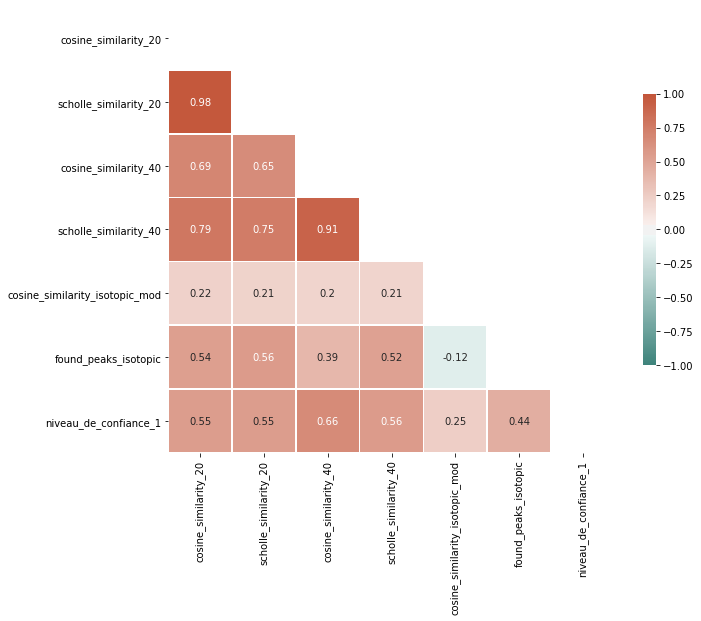

In [288]:
correlation = df1[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

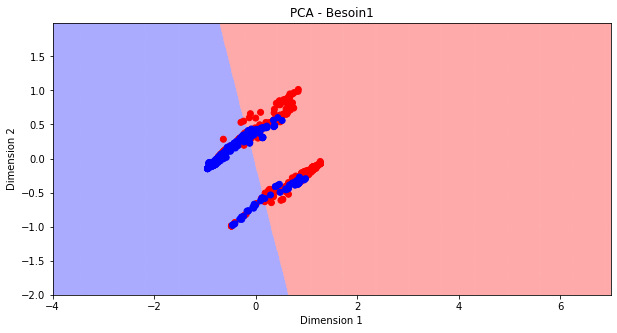

In [291]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,7
y_min, y_max = -2,2


X, y = X, y
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap=cmap_bold)
plt.show()

## 1- Random Forest

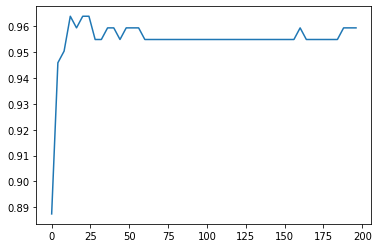

In [131]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train, y_train)  
    pred_y = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [132]:
RFC_ineris = RandomForestClassifier(random_state=7, n_estimators=20)
RFC_ineris.fit(X_train, y_train)  
pred_y = RFC_ineris.predict(X_test)
accuracy = metrics.accuracy_score(y_test, pred_y)
print(accuracy)

0.9594594594594594


In [133]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[ 98   5]
 [  4 115]]

Normalized confusion matrix:
[0.95145631 0.04854369]
[0.03361345 0.96638655]


## 2- Decision tree

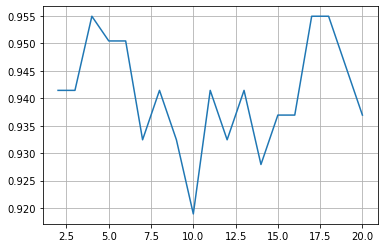

In [134]:
acc=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(X_train,y_train)
    prediction4=model.predict(X_test)
    acc.append(metrics.accuracy_score(prediction4,y_test))
plt.plot(range(2,21), acc)
plt.grid()

In [135]:
DTC4_ineris=DecisionTreeClassifier(max_leaf_nodes=4)
DTC4_ineris.fit(X_train,y_train)
prediction4=DTC4_ineris.predict(X_test)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test))

The accuracy of the Decision Tree is 0.954954954954955


In [136]:
X_train.columns

Index(['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40',
       'cosine_similarity_isotopic_mod', 'found_peaks_isotopic'],
      dtype='object')

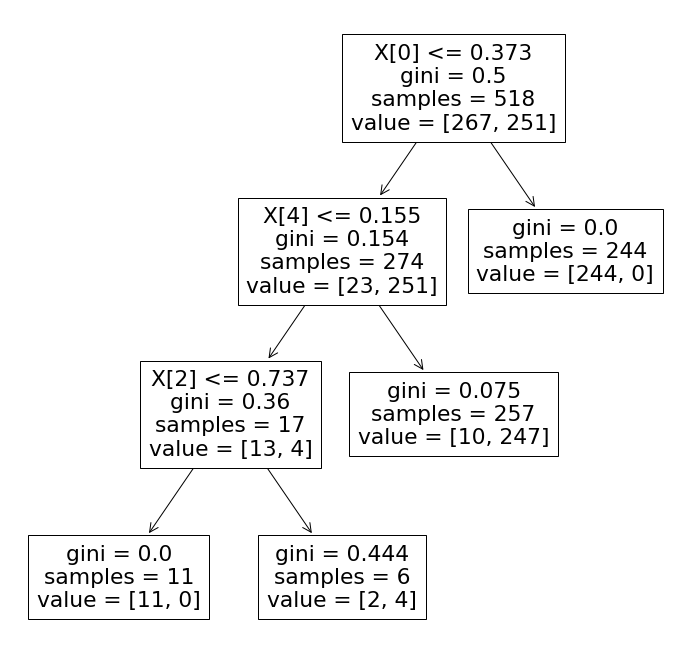

In [137]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC4_ineris)

# V- Dont use level 3

## 1-Let mzml 18 to test on it

In [292]:
df_3 = pd.read_excel('dataset_boucle_retour_to_use.xlsx')
del df_3['Unnamed: 0']
df_3 = df_3[['id_mzml', 'id_molecule', 'source', 'retention_time_exp', 'retention_time', 'rt_diff', 
       'tic', 'mass_exp', 'mass', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40', 'root_similarity_20', 'root_similarity_40', 
       'cosine_similarity_isotopic_mod', 'num_isotopic_exp_peaks', 'num_isotopic_the_peaks', 
       'acquisition_mode', 'niveau_de_confiance']]
df_3['found_peaks_isotopic'] = df_3['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_3 = df_3[df_3['niveau_de_confiance']!='3']
df_3['niveau_de_confiance_1'] = df_3['niveau_de_confiance'].map({'1': 1, '2A': 1, '2B': 1, '0': 0, 0: 0, 2: 1})

In [293]:
df1_non18_3 = df_3[(df_3['source']=='Agilent')&(df_3['acquisition_mode']=='Data independant')&(df_3['id_mzml']!=18)]
df_final_18_3 = pd.read_csv('final.csv')
df_final_18_3 = df_final_18_3[df_final_18_3['id_mzml']==18]
def sampling_k_elements(group, k=220):
    if len(group) < k:
        return group
    return group.sample(k)

df1_non18_3 = df1_non18_3.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

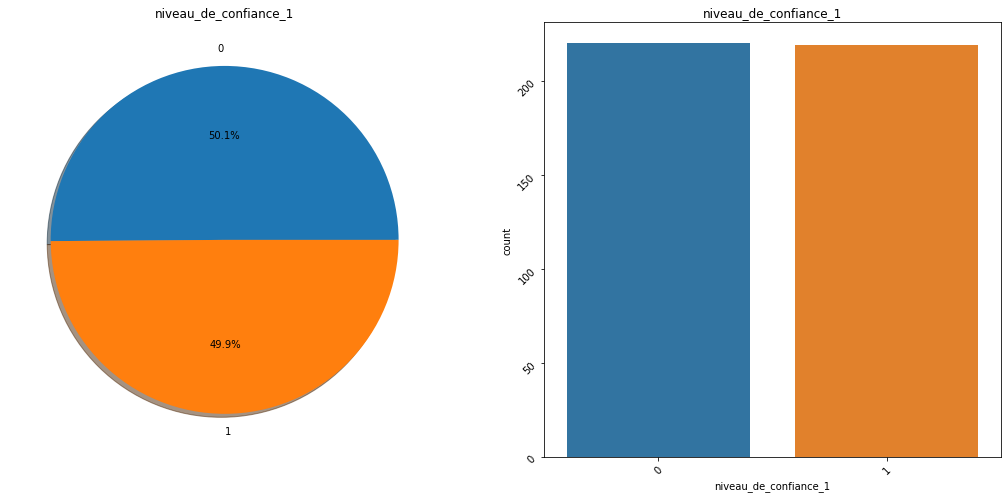

In [294]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1_non18_3[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1_non18_3,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [295]:
X1 = ['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

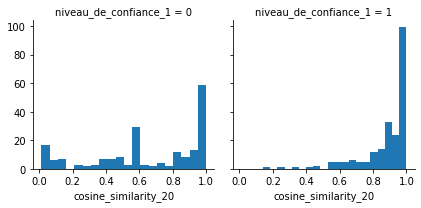

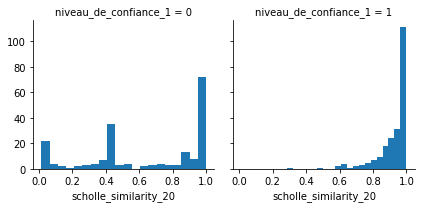

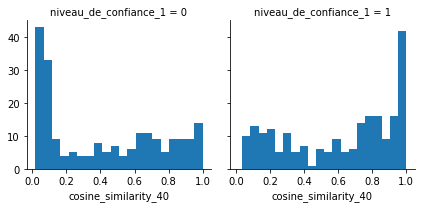

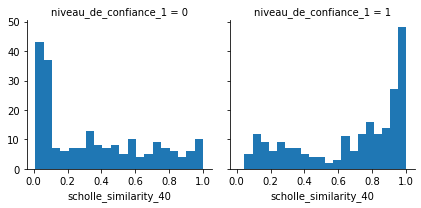

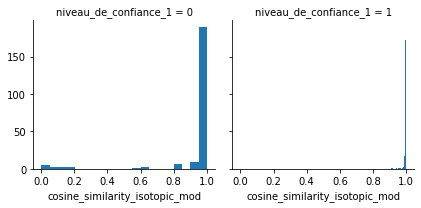

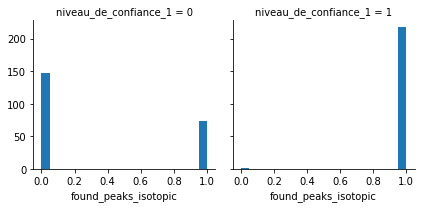

In [296]:
for i in X1:
    g = sns.FacetGrid(df1_non18_3, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [297]:
X_non18_3 = df1_non18_3[X1]

y_non18_3 = df1_non18_3['niveau_de_confiance_1']

In [298]:
for c in X1:
    no_missing = df1_non18_3[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
25
scholle_similarity_20
25
cosine_similarity_40
11
scholle_similarity_40
11
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [299]:
X_non18_3 = X_non18_3.fillna(0)

In [300]:
X_train_non18_3, X_test_non18_3, y_train_non18_3, y_test_non18_3 = train_test_split(X_non18_3,y_non18_3,test_size=0.3)

In [301]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [302]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [303]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [304]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [305]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [306]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [307]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_non18_3, y_train_non18_3, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [308]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
4,Random Forest,0.417181,0.073200,0.954624,0.957348,0.954762,0.954529,0.988869
5,K-Nearest Neighbors,0.009614,0.025513,0.954624,0.956282,0.955179,0.954576,0.974970
1,Decision Tree,0.007126,0.017126,0.941505,0.943374,0.941161,0.941407,0.941161
0,Logistic Regression,0.043740,0.021022,0.918817,0.921241,0.918869,0.918709,0.968006
2,Support Vector Machine,0.014857,0.020514,0.899355,0.906452,0.897351,0.898763,0.953958
3,Linear Discriminant Analysis,0.007738,0.014407,0.882796,0.893372,0.885804,0.882145,0.971161
6,Bayes,0.009187,0.017513,0.866882,0.876034,0.870208,0.866383,0.951577


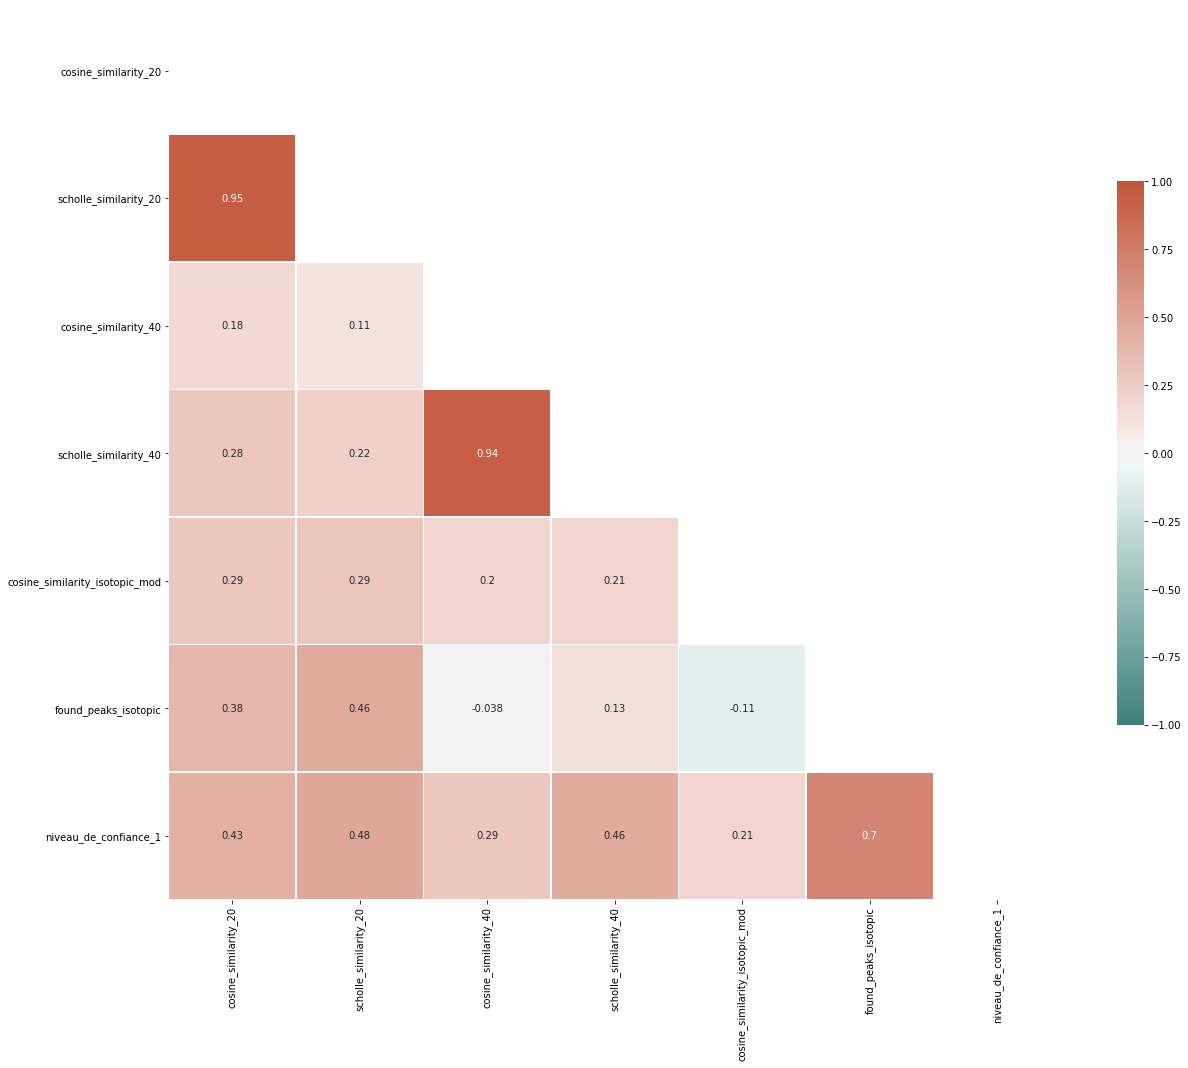

In [309]:
correlation = df1_non18_3[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

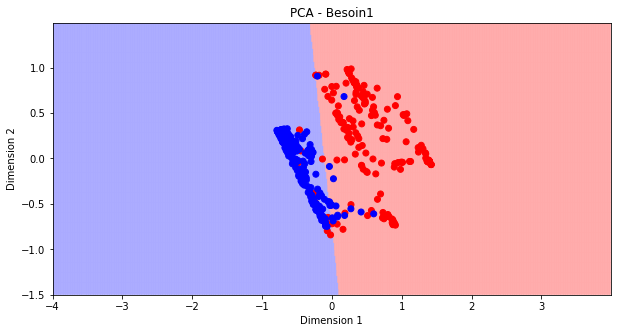

In [311]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,4
y_min, y_max = -1.5,1.5


X_non18_3, y_non18_3 = X_non18_3, y_non18_3
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X_non18_3)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y_non18_3)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_non18_3,cmap=cmap_bold)
plt.show()

## 1- Random Forest

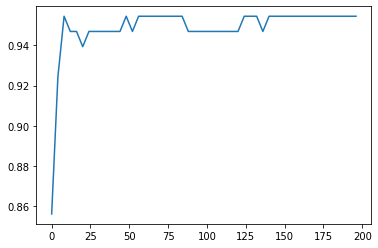

In [157]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train_non18_3, y_train_non18_3)  
    pred_y = model.predict(X_test_non18_3)
    accuracy = metrics.accuracy_score(y_test_non18_3, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [158]:
RFC_non18_3 = RandomForestClassifier(random_state=7, n_estimators=50)
RFC_non18_3.fit(X_train_non18_3, y_train_non18_3)  
pred_y = RFC_non18_3.predict(X_test_non18_3)
accuracy = metrics.accuracy_score(y_test_non18_3, pred_y)
print(accuracy)

0.9545454545454546


In [159]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non18_3, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[64  3]
 [ 3 62]]

Normalized confusion matrix:
[0.95522388 0.04477612]
[0.04615385 0.95384615]


In [312]:
LR_non18_3 = LogisticRegression(random_state=7)
LR_non18_3.fit(X_train_non18_3, y_train_non18_3)  
pred_y = LR_non18_3.predict(X_test_non18_3)
accuracy = metrics.accuracy_score(y_test_non18_3, pred_y)
print(accuracy)

0.9242424242424242


In [313]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non18_3, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[55  5]
 [ 5 67]]

Normalized confusion matrix:
[0.91666667 0.08333333]
[0.06944444 0.93055556]


In [314]:
df_final_18 = pd.read_csv('final.csv')
df_final_18 = df_final_18[df_final_18['id_mzml']==18]
df_final_18['found_peaks_isotopic'] = df_final_18['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_18 = df_final_18[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_18 = df_final_18.fillna(0)
df_final_18['predicted_class'] = RFC_non18.predict(df_final_18[X1])
df_final_18['prob'] = RFC_non18.predict_proba(df_final_18[X1])[:,1:2]
df_final_18['predicted_class_LR'] = LR_non18_3.predict(df_final_18[X1])
df_final_18['prob_LR'] = LR_non18_3.predict_proba(df_final_18[X1])[:,1:2]

In [328]:
df_final_18[(df_final_18['prob_LR']>0)&(df_final_18['prob_LR']<=0.002)].sort_values(by=['prob_LR'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob,predicted_class_LR,prob_LR
9079,18,58,8.197850,0.097773,0.025090,0.039373,0.048422,0.973458,0,0,0.00,0,0.001983
10471,18,1471,9.792250,0.035897,0.008456,0.085743,0.051765,0.979787,0,0,0.00,0,0.001973
9549,18,469,9.252217,0.033008,0.018994,0.058267,0.048148,0.991729,0,0,0.00,0,0.001959
9868,18,699,7.349150,0.025623,0.008262,0.086807,0.046994,0.983350,0,0,0.00,0,0.001943
10124,18,954,10.730917,0.039055,0.019443,0.069316,0.048535,0.965006,0,0,0.00,0,0.001934
10161,18,1012,13.071100,0.017699,0.004553,0.170881,0.078853,0.796815,0,0,0.04,0,0.001871
9959,18,763,7.169133,0.091246,0.095380,0.000000,0.000000,0.991655,0,0,0.00,0,0.001867
9403,18,372,11.849567,0.027852,0.017526,0.063284,0.046361,0.943724,0,0,0.00,0,0.001858
10101,18,907,6.050500,0.007121,0.002449,0.083440,0.041215,0.974985,0,0,0.00,0,0.001857
9171,18,187,6.924833,0.035457,0.112298,0.015713,0.014187,0.933503,0,0,0.00,0,0.001844


In [160]:
df_final_18 = pd.read_csv('final.csv')
df_final_18 = df_final_18[df_final_18['id_mzml']==18]
df_final_18['found_peaks_isotopic'] = df_final_18['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_18 = df_final_18[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_18 = df_final_18.fillna(0)
df_final_18['predicted_class'] = RFC_non18.predict(df_final_18[X1])
df_final_18['prob'] = RFC_non18.predict_proba(df_final_18[X1])[:,1:2]
df_final_18['predicted_class_3'] = RFC_non18_3.predict(df_final_18[X1])
df_final_18['prob_3'] = RFC_non18_3.predict_proba(df_final_18[X1])[:,1:2]

In [161]:
df_final_18[(df_final_18['prob_3']>0.95)&(df_final_18['prob_3']<=1)].sort_values(by=['prob_3'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob,predicted_class_3,prob_3
10467,18,1459,9.059333,0.974546,0.974664,0.935901,0.956343,0.998191,1,1,1.00,1,1.00
9277,18,302,8.956467,0.948186,0.974361,0.776787,0.732997,0.999185,1,1,1.00,1,1.00
10232,18,1103,15.552700,0.923109,0.931604,0.849771,0.967314,0.999326,1,1,1.00,1,1.00
10049,18,837,6.179083,0.835116,0.897163,0.826269,0.783676,0.998795,1,1,1.00,1,1.00
10269,18,1137,12.428167,0.956024,0.927710,0.895251,0.963545,0.997560,1,1,0.98,1,1.00
9981,18,779,8.956467,0.986660,0.991226,0.971266,0.975097,0.999185,1,1,0.98,1,1.00
9881,18,711,10.820933,0.991525,0.992009,0.937275,0.970483,0.999373,1,1,1.00,1,1.00
9879,18,701,8.943617,0.992320,0.991872,0.847141,0.829120,0.999927,1,1,1.00,1,1.00
9798,18,654,3.594633,0.943568,0.950175,0.836735,0.924170,0.999721,1,1,1.00,1,1.00
10311,18,1221,12.595333,0.894608,0.975711,0.834980,0.756914,0.990896,1,1,0.98,1,1.00


In [162]:
df_final_18[(df_final_18['prob_3']<=0.8)&(df_final_18['prob_3']>0.7)].sort_values(by=['prob_3'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob,predicted_class_3,prob_3
9678,18,573,16.054150,0.737814,0.589482,0.312658,0.281749,0.994369,1,1,0.72,1,0.80
10112,18,939,13.096817,0.492942,0.911516,0.257897,0.322608,0.993175,1,1,0.86,1,0.80
9736,18,612,13.778300,0.654618,0.678101,0.191353,0.209847,0.994402,1,1,0.76,1,0.80
9813,18,664,11.039517,0.553350,0.730872,0.790764,0.851150,0.945673,1,1,0.90,1,0.80
9730,18,604,7.914900,0.436859,0.713634,0.289105,0.266153,0.996093,1,1,0.86,1,0.80
9869,18,700,6.474817,0.287403,0.554139,0.629456,0.732510,0.999961,1,1,0.58,1,0.80
9987,18,782,10.975217,0.993893,0.994846,0.945674,0.959381,0.996987,1,1,0.98,1,0.80
9286,18,310,8.763600,0.986503,0.984411,0.992384,0.993482,0.993201,1,1,1.00,1,0.80
9467,18,414,12.903917,0.702203,0.812259,0.611277,0.785883,0.992450,1,1,0.96,1,0.80
9188,18,220,7.053417,0.967381,0.835153,0.253602,0.365755,0.995664,1,1,0.84,1,0.80


In [163]:
df_final_18[df_final_18.id_molecule.isin([1473, 981, 1007, 1103, 1222, 976, 837]
                                        )].sort_values(by=['prob_3'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class,prob,predicted_class_3,prob_3
10049,18,837,6.179083,0.835116,0.897163,0.826269,0.783676,0.998795,1,1,1.00,1,1.00
10232,18,1103,15.552700,0.923109,0.931604,0.849771,0.967314,0.999326,1,1,1.00,1,1.00
10312,18,1222,10.628067,0.915694,0.923543,0.130229,0.449235,0.999552,1,1,0.94,1,0.94
10233,18,1103,15.835567,0.794159,0.865148,0.452254,0.758521,0.963784,1,1,0.78,1,0.88
10472,18,1473,10.692350,0.943900,0.943604,0.372416,0.543650,0.941869,1,1,0.86,1,0.82
10128,18,976,10.988083,0.837593,0.887916,0.419510,0.525174,0.994445,1,1,0.88,1,0.70
10149,18,1007,8.930767,0.100078,0.146226,0.133253,0.121140,0.854999,1,0,0.14,0,0.12
10131,18,981,12.029583,0.930757,0.938034,0.039118,0.051545,0.968735,0,0,0.44,0,0.08
10150,18,1007,10.409433,0.071941,0.070992,0.110930,0.093109,0.923375,0,0,0.00,0,0.08


## 2- Let mzml 28 for test 

In [329]:
df_3 = pd.read_excel('dataset_boucle_retour_to_use.xlsx')
del df_3['Unnamed: 0']
df_3 = df_3[['id_mzml', 'id_molecule', 'source', 'retention_time_exp', 'retention_time', 'rt_diff', 
       'tic', 'mass_exp', 'mass', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40', 'root_similarity_20', 'root_similarity_40', 
       'cosine_similarity_isotopic_mod', 'num_isotopic_exp_peaks', 'num_isotopic_the_peaks', 
       'acquisition_mode', 'niveau_de_confiance']]
df_3['found_peaks_isotopic'] = df_3['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_3 = df_3[df_3['niveau_de_confiance']!='3']
df_3['niveau_de_confiance_1'] = df_3['niveau_de_confiance'].map({'1': 1, '2A': 1, '2B': 1, '0': 0, 0: 0, 2: 1})

In [330]:
df1_non28_3 = df_3[(df_3['source']=='Agilent')&(df_3['acquisition_mode']=='Data independant')&(df_3['id_mzml']!=28)]
df_final_28_3 = pd.read_csv('final.csv')
df_final_28_3 = df_final_28_3[df_final_28_3['id_mzml']==28]
def sampling_k_elements(group, k=220):
    if len(group) < k:
        return group
    return group.sample(k)

df1_non28_3 = df1_non28_3.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

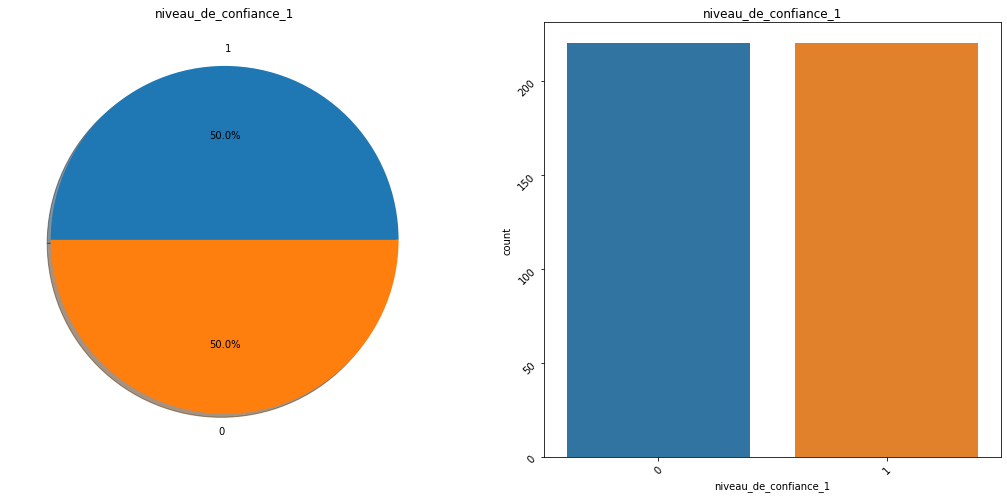

In [331]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1_non28_3[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1_non28_3,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [332]:
X1 = ['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

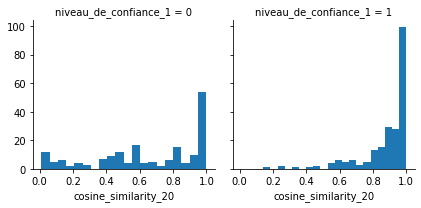

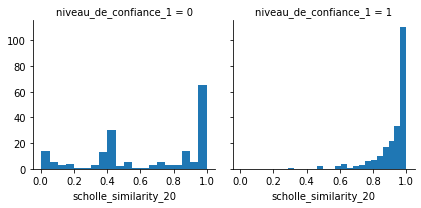

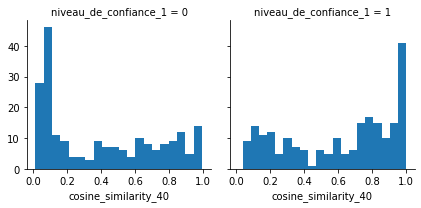

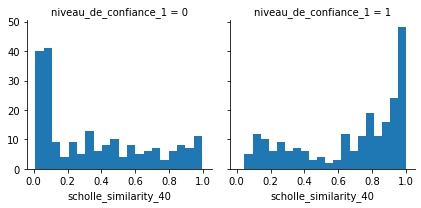

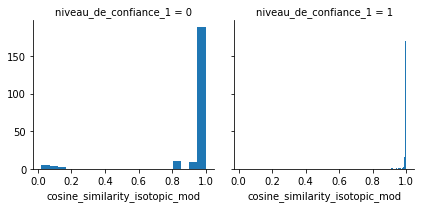

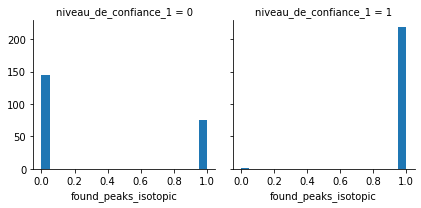

In [333]:
for i in X1:
    g = sns.FacetGrid(df1_non28_3, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [334]:
X_non28_3 = df1_non28_3[X1]

y_non28_3 = df1_non28_3['niveau_de_confiance_1']

In [335]:
for c in X1:
    no_missing = df1_non28_3[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

cosine_similarity_20
39
scholle_similarity_20
39
cosine_similarity_40
10
scholle_similarity_40
10
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [336]:
X_non28_3 = X_non28_3.fillna(0)

In [337]:
X_train_non28_3, X_test_non28_3, y_train_non28_3, y_test_non28_3 = train_test_split(X_non28_3,y_non28_3,test_size=0.3)

In [338]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [339]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [340]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [341]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [342]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [343]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [344]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_non28_3, y_train_non28_3, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [345]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
4,Random Forest,0.388260,0.061037,0.948172,0.949769,0.949167,0.948119,0.981637
5,K-Nearest Neighbors,0.004800,0.014200,0.922258,0.925538,0.923041,0.921965,0.957777
1,Decision Tree,0.007906,0.016901,0.912473,0.915868,0.912446,0.912019,0.912446
3,Linear Discriminant Analysis,0.007298,0.011701,0.906129,0.917012,0.908095,0.904859,0.962351
0,Logistic Regression,0.030991,0.023172,0.899785,0.904473,0.900357,0.899419,0.957017
2,Support Vector Machine,0.016347,0.025489,0.889892,0.899627,0.887708,0.888814,0.959484
6,Bayes,0.003994,0.007406,0.844409,0.857716,0.848438,0.843244,0.942013


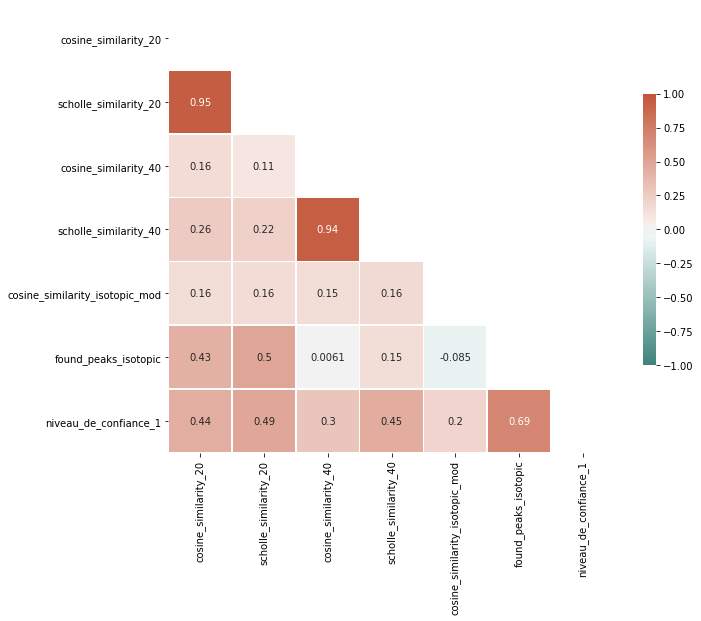

In [346]:
correlation = df1_non28_3[X1+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

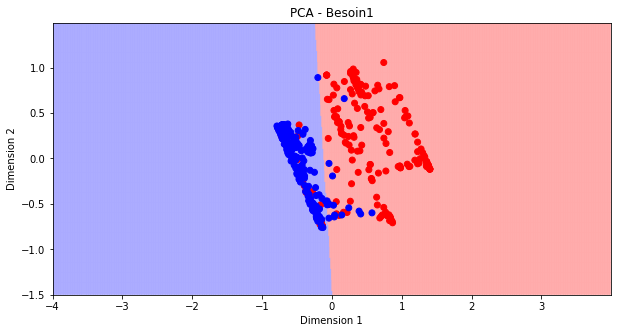

In [347]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,4
y_min, y_max = -1.5,1.5


X_non28_3, y_non28_3 = X_non28_3, y_non28_3
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X_non28_3)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y_non28_3)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_non28_3,cmap=cmap_bold)
plt.show()

## 1- Random Forest

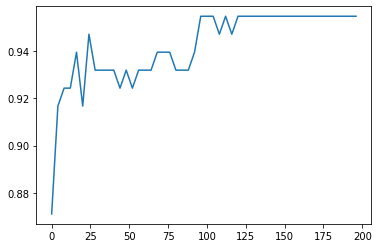

In [183]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train_non28_3, y_train_non28_3)  
    pred_y = model.predict(X_test_non28_3)
    accuracy = metrics.accuracy_score(y_test_non28_3, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [184]:
RFC_non28_3 = RandomForestClassifier(random_state=7, n_estimators=50)
RFC_non28_3.fit(X_train_non28_3, y_train_non28_3)  
pred_y = RFC_non28_3.predict(X_test_non28_3)
accuracy = metrics.accuracy_score(y_test_non28_3, pred_y)
print(accuracy)

0.9242424242424242


In [185]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non28_3, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[56  8]
 [ 2 66]]

Normalized confusion matrix:
[0.875 0.125]
[0.02941176 0.97058824]


In [348]:
LR_non28_3 = LogisticRegression(random_state=7)
LR_non28_3.fit(X_train_non28_3, y_train_non28_3)  
pred_y = LR_non28_3.predict(X_test_non28_3)
accuracy = metrics.accuracy_score(y_test_non28_3, pred_y)
print(accuracy)

0.9318181818181818


In [349]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non28_3, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[54  5]
 [ 4 69]]

Normalized confusion matrix:
[0.91525424 0.08474576]
[0.05479452 0.94520548]


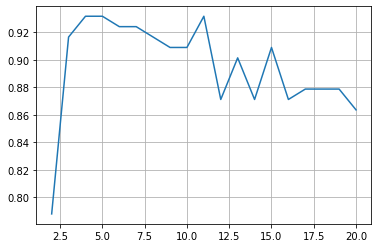

In [186]:
acc=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(X_train_non28_3, y_train_non28_3)
    prediction4=model.predict(X_test_non28_3)
    acc.append(metrics.accuracy_score(prediction4,y_test_non28_3))
plt.plot(range(2,21), acc)
plt.grid()

In [187]:
DTC_non28_3=DecisionTreeClassifier(max_leaf_nodes=4)
DTC_non28_3.fit(X_train_non28_3, y_train_non28_3)
prediction4=DTC_non28_3.predict(X_test_non28_3)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test_non28_3))

The accuracy of the Decision Tree is 0.9318181818181818


In [188]:
X_train_non28_3.columns

Index(['cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic'],
      dtype='object')

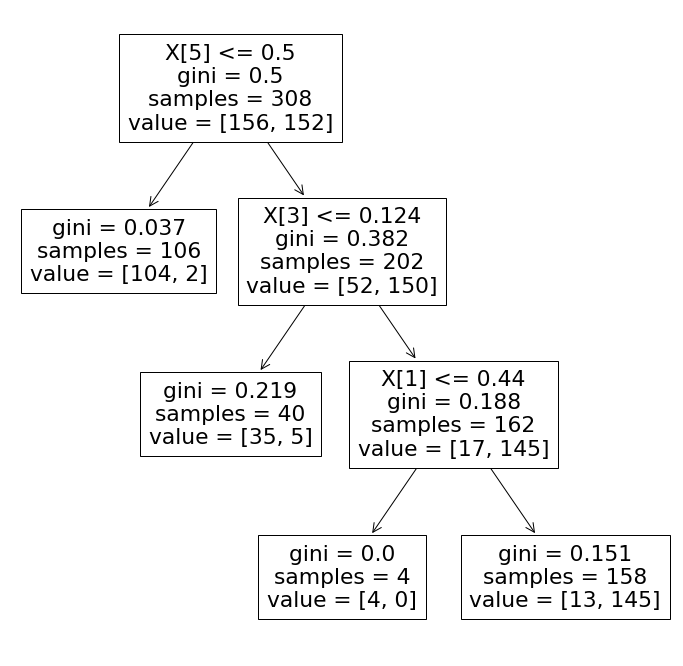

In [189]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC_non28_3)

In [190]:
X1

['cosine_similarity_20',
 'scholle_similarity_20',
 'cosine_similarity_40',
 'scholle_similarity_40',
 'cosine_similarity_isotopic_mod',
 'found_peaks_isotopic']

In [191]:

# df_final_28 = pd.read_csv('final.csv')
# df_final_28 = df_final_28[df_final_28['id_mzml']==28]
# df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
# df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
# df_final_28 = df_final_28.fillna(0)
# df_final_28['predicted_class_3'] = RFC_non28_3.predict(df_final_28[X1])
# df_final_28['prob_3'] = RFC_non28_3.predict_proba(df_final_28[X1])[:,1:2]



X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_28 = pd.read_csv('final.csv')
df_final_28 = df_final_28[df_final_28['id_mzml']==28]
df_final_28['rt_diff']=df_final_28['retention_time_exp']-df_final_28['retention_time']
df_final_28['rt_diff_abs'] = df_final_28['rt_diff'].apply(lambda x : abs(x))
df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp']+X1_ret]
# df_final_28_ineris = df_final_28[]
# df_final_28
df_final_28[X1] = df_final_28[X1].fillna(0)
df_final_28['prob'] = df_final_28[X1_ret].apply(lambda x: RFC_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
df_final_28
# df_final_28['predicted_class_3'] = RFC_non28_3.predict(df_final_28[X1])
# df_final_28['prob_3'] = RFC_non28_3.predict_proba(df_final_28[X1])[:,1:2]
# df_final_28['predicted_class_rt'] = RFC_ineris.predict(df_final_28[X1_ret])
# df_final_28['prob_rt'] = RFC_ineris.predict_proba(df_final_28[X1_ret])[:,1:2]

,id_mzml,id_molecule,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob
14806,28,0,5.845100,5.196900,0.373945,0.389976,0.762951,0.685997,0.980761,0,0.05
14807,28,0,6.205133,4.836867,0.338911,0.342961,0.768403,0.676759,0.980761,0,0.05
14808,28,0,10.949717,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.90
14809,28,0,11.489750,0.447750,0.278953,0.234525,0.730511,0.601869,0.980761,0,0.10
14810,28,0,11.965500,0.923500,0.263550,0.222453,0.563820,0.537167,0.980761,0,0.05
...,...,...,...,...,...,...,...,...,...,...,...
16376,28,1499,8.468133,NaN,0.228611,0.559983,0.331296,0.336332,0.984958,1,0.54
16377,28,1502,13.637033,NaN,0.077432,0.094474,0.124269,0.137998,0.167735,1,0.18
16378,28,1506,9.612483,NaN,0.014696,0.007022,0.620210,0.586140,0.983259,0,0.00
16379,28,1506,10.975433,NaN,0.014696,0.007022,0.349424,0.237950,0.130302,1,0.04


In [192]:
df_final_28[(df_final_28['prob']>0.95)&(df_final_28['prob']<=1)].sort_values(by=['prob'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob
14831,28,11,13.187000,0.151000,0.418776,0.511349,0.487789,0.505584,0.994621,1,1.00
15042,28,276,12.891267,0.075733,0.921305,0.971284,0.879800,0.953773,0.992450,1,1.00
15670,28,711,10.821133,NaN,0.989659,0.990382,0.942402,0.972474,0.999133,1,1.00
15597,28,654,3.582050,NaN,0.923530,0.927460,0.821716,0.903395,0.999721,1,1.00
15846,28,856,10.113950,NaN,0.957981,0.901886,0.965824,0.980547,0.999893,1,1.00
15941,28,978,11.399750,NaN,0.908733,0.935872,0.999232,0.999407,0.999554,1,1.00
15476,28,573,13.572733,NaN,0.858413,0.873000,0.757515,0.767521,0.999947,1,1.00
14880,28,54,10.306817,0.070183,0.325348,0.326123,0.662600,0.867468,0.999538,1,1.00
16133,28,1150,11.284017,NaN,0.996073,0.996361,0.872239,0.922566,0.999359,1,1.00
16216,28,1282,20.348883,NaN,0.990941,0.999137,0.782219,0.884408,0.999920,1,1.00


In [193]:
df_final_28[df_final_28.id_molecule.isin([414])].sort_values(by=['prob'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob
15266,28,414,12.891267,NaN,0.807841,0.875167,0.809953,0.913352,0.992450,1,0.94
15262,28,414,7.760933,NaN,0.030551,0.024796,0.025780,0.021302,0.988918,1,0.04
15263,28,414,8.018100,NaN,0.032556,0.025907,0.044805,0.040059,0.990952,0,0.00
15264,28,414,8.326683,NaN,0.031276,0.025088,0.028504,0.022696,0.122206,1,0.00
15265,28,414,12.479817,NaN,0.028399,0.018380,0.032732,0.027790,0.990952,0,0.00


In [194]:
X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_27 = pd.read_csv('final.csv')
df_final_27 = df_final_27[df_final_27['id_mzml']==27]
df_final_27['rt_diff']=df_final_27['retention_time_exp']-df_final_27['retention_time']
df_final_27['rt_diff_abs'] = df_final_27['rt_diff'].apply(lambda x : abs(x))
df_final_27['found_peaks_isotopic'] = df_final_27['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_27 = df_final_27[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_27 = df_final_27.fillna(0)
df_final_27['predicted_class_3'] = RFC_non28_3.predict(df_final_27[X1])
df_final_27['prob_3'] = RFC_non28_3.predict_proba(df_final_27[X1])[:,1:2]

In [195]:
df_final_27[(df_final_27['prob_3']>-1)&(df_final_27['prob_3']<=0.1)].sort_values(by=['prob_3'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class_3,prob_3
14787,27,1052,8.736534,0.027409,0.007142,0.511265,0.362880,0.992034,1,0,0.1
14774,27,871,8.736534,0.029498,0.007674,0.515445,0.367468,0.992034,1,0,0.1
14788,27,1052,9.507400,0.027409,0.007142,0.511265,0.362880,0.992034,1,0,0.1
14775,27,871,9.507400,0.029498,0.007674,0.515445,0.367468,0.992034,1,0,0.1
14654,27,337,13.640000,0.532016,0.543272,0.746640,0.701663,0.992202,0,0,0.1
...,...,...,...,...,...,...,...,...,...,...,...
14773,27,871,8.136967,0.029498,0.007674,0.515445,0.367468,0.011464,1,0,0.0
14772,27,871,7.194833,0.029498,0.007674,0.515445,0.367468,0.974775,0,0,0.0
14757,27,747,13.511517,0.000000,0.000000,0.000000,0.000000,0.646492,1,0,0.0
14768,27,793,7.858617,0.000000,0.000000,0.053551,0.037373,0.101911,1,0,0.0


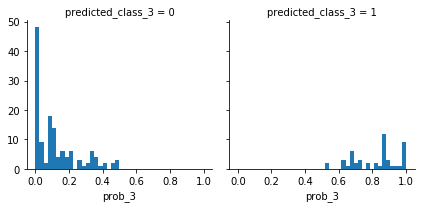

In [196]:
g = sns.FacetGrid(df_final_27, col='predicted_class_3')
g.map(plt.hist, 'prob_3', bins=20)

### let mzml 28 to test only for ineris data

In [350]:
df_3 = pd.read_excel('dataset_boucle_retour_to_use.xlsx')
del df_3['Unnamed: 0']
df_3 = df_3[['id_mzml', 'id_molecule', 'source', 'retention_time_exp', 'retention_time', 'rt_diff', 
       'tic', 'mass_exp', 'mass', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40', 'root_similarity_20', 'root_similarity_40', 
       'cosine_similarity_isotopic_mod', 'num_isotopic_exp_peaks', 'num_isotopic_the_peaks', 
       'acquisition_mode', 'niveau_de_confiance']]
df_3['found_peaks_isotopic'] = df_3['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_3 = df_3[df_3['niveau_de_confiance']!='3']
df_3['niveau_de_confiance_1'] = df_3['niveau_de_confiance'].map({'1': 1, '2A': 1, '2B': 1, '0': 0, 0: 0, 2: 1})

In [351]:
df1_non28_3_ineris = df_3[(df_3['source']=='INERIS')&(df_3['acquisition_mode']=='Data independant')&(df_3['id_mzml']!=28)]
df1_non28_3_ineris['rt_diff_abs'] = df1_non28_3_ineris['rt_diff'].apply(lambda x : abs(x))
df_final_28_3 = pd.read_csv('final.csv')
df_final_28_3 = df_final_28_3[df_final_28_3['id_mzml']==28]
def sampling_k_elements(group, k=360):
    if len(group) < k:
        return group
    return group.sample(k)

df1_non28_3_ineris = df1_non28_3_ineris.groupby('niveau_de_confiance_1').apply(sampling_k_elements).reset_index(drop=True)

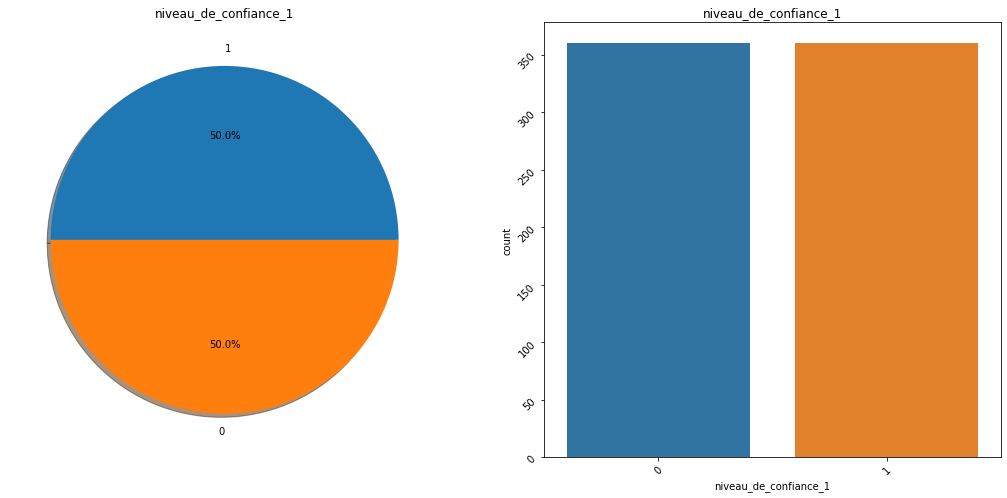

In [352]:
col = "niveau_de_confiance_1"
f,ax=plt.subplots(1,2,figsize=(18,8))
df1_non28_3_ineris[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(col)
ax[0].set_ylabel('')
sns.countplot(col,data=df1_non28_3_ineris,ax=ax[1])
ax[1].set_title(col)
ax[1].tick_params(labelrotation=45)
plt.show()

In [353]:
X1_rt = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']

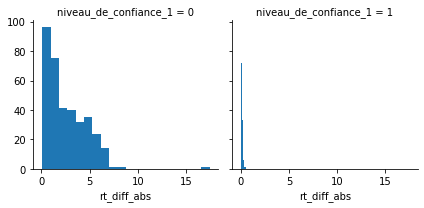

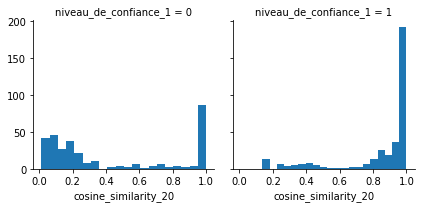

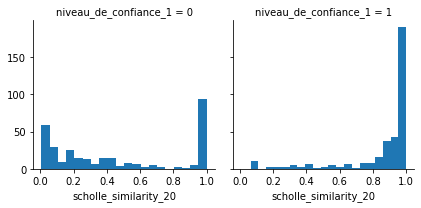

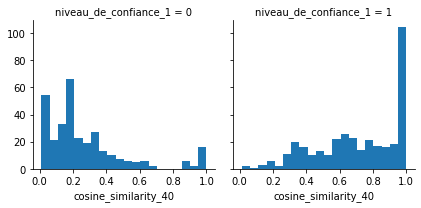

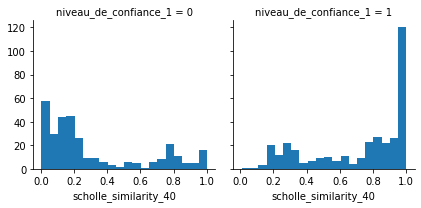

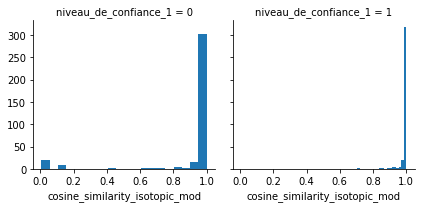

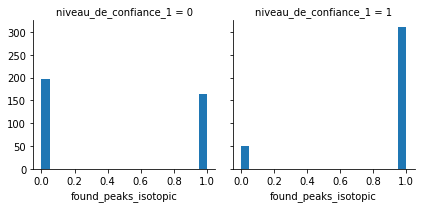

In [354]:
for i in X1_rt:
    g = sns.FacetGrid(df1_non28_3_ineris, col='niveau_de_confiance_1')
    g.map(plt.hist, i, bins=20)

In [355]:
X_non28_3_ineris = df1_non28_3_ineris[X1_rt]

y_non28_3_ineris = df1_non28_3_ineris['niveau_de_confiance_1']

In [356]:
for c in X1_rt:
    no_missing = df1_non28_3_ineris[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

rt_diff_abs
No missing values
 
cosine_similarity_20
50
scholle_similarity_20
50
cosine_similarity_40
49
scholle_similarity_40
49
cosine_similarity_isotopic_mod
No missing values
 
found_peaks_isotopic
No missing values
 


In [357]:
X_non28_3_ineris = X_non28_3_ineris.fillna(0)

In [358]:
X_train_non28_3_ineris, X_test_non28_3_ineris, y_train_non28_3_ineris, y_test_non28_3_ineris = train_test_split(X_non28_3_ineris,y_non28_3_ineris,test_size=0.3)

In [359]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

In [360]:
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [361]:
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()

In [362]:
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [363]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [364]:
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()

In [365]:
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train_non28_3_ineris, y_train_non28_3_ineris, scoring=scoring, cv=10)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [366]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, forest_roc, KNN_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
4,Random Forest,0.454885,0.080256,0.976078,0.976277,0.975873,0.976059,0.993151
1,Decision Tree,0.009197,0.022200,0.954314,0.955206,0.954392,0.954295,0.954392
2,Support Vector Machine,0.021372,0.017468,0.954078,0.961034,0.952083,0.953720,0.993317
0,Logistic Regression,0.032806,0.019358,0.952157,0.958470,0.950475,0.951813,0.991418
5,K-Nearest Neighbors,0.009163,0.033877,0.946235,0.954482,0.944083,0.945724,0.987996
6,Bayes,0.012007,0.024403,0.934431,0.936617,0.935381,0.934386,0.986788
3,Linear Discriminant Analysis,0.013100,0.026852,0.914627,0.920003,0.912674,0.914189,0.956868


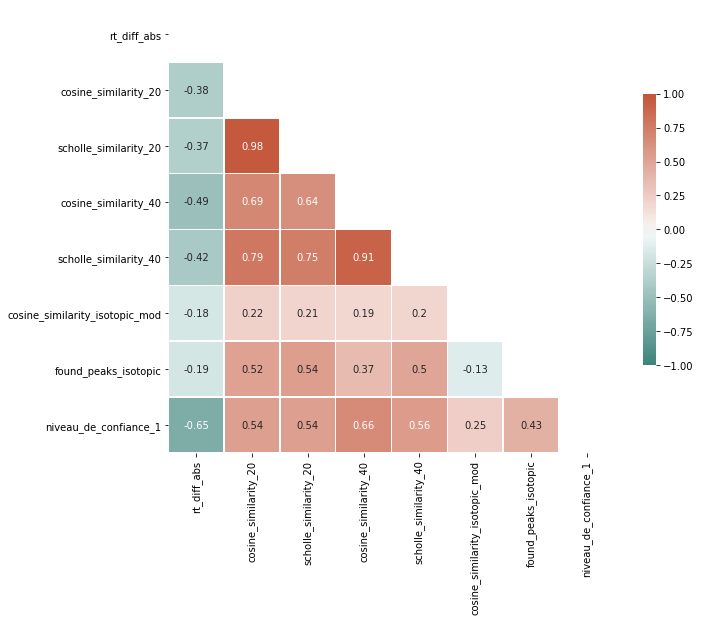

In [367]:
correlation = df1_non28_3_ineris[X1_rt+['niveau_de_confiance_1']].corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

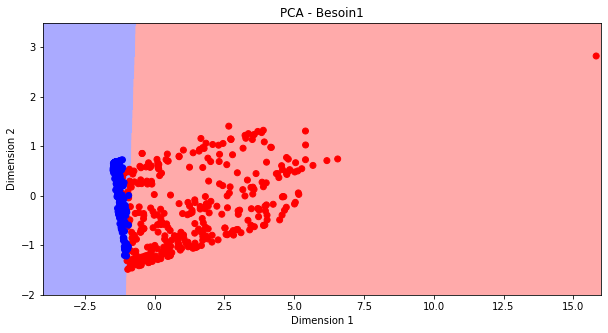

In [368]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


h = .01
x_min, x_max = -4,16
y_min, y_max = -2,3.5


X_non28_3_ineris, y_non28_3_ineris = X_non28_3_ineris, y_non28_3_ineris
# selecting first 2 components of PCA
X_pca = PCA().fit_transform(X_non28_3_ineris)
X_selected = X_pca[:,:2]
# training classifier and evaluating on the whole plane
clf = LogisticRegression()
clf.fit(X_selected,y_non28_3_ineris)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Besoin1')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_non28_3_ineris,cmap=cmap_bold)
plt.show()

## 1- Random Forest

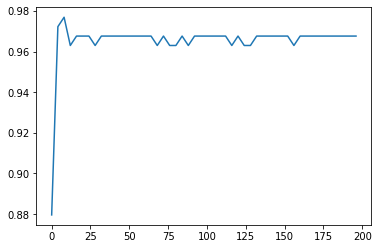

In [216]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(1,201,4):
    model = RandomForestClassifier(random_state=7, n_estimators=i)
    model.fit(X_train_non28_3_ineris, y_train_non28_3_ineris)  
    pred_y = model.predict(X_test_non28_3_ineris)
    accuracy = metrics.accuracy_score(y_test_non28_3_ineris, pred_y)
    accuracies.append(accuracy)
plt.plot(range(0,200,4), accuracies)

In [217]:
RFC_non28_3_ineris = RandomForestClassifier(random_state=7, n_estimators=25)
RFC_non28_3_ineris.fit(X_train_non28_3_ineris, y_train_non28_3_ineris)  
pred_y = RFC_non28_3_ineris.predict(X_test_non28_3_ineris)
accuracy = metrics.accuracy_score(y_test_non28_3_ineris, pred_y)
print(accuracy)

0.9675925925925926


In [218]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non28_3_ineris, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[ 93   5]
 [  2 116]]

Normalized confusion matrix:
[0.94897959 0.05102041]
[0.01694915 0.98305085]


In [369]:
LR_non28_3_ineris = LogisticRegression(random_state=7)
LR_non28_3_ineris.fit(X_train_non28_3_ineris, y_train_non28_3_ineris)  
pred_y = LR_non28_3_ineris.predict(X_test_non28_3_ineris)
accuracy = metrics.accuracy_score(y_test_non28_3_ineris, pred_y)
print(accuracy)

0.9629629629629629


In [370]:
# Calculate the confusion matrix itself
confusion = metrics.confusion_matrix(y_test_non28_3_ineris, pred_y)
print(f"Confusion matrix:\n{confusion}")


# Normalizing by the true label counts to get rates
print(f"\nNormalized confusion matrix:")
for row in confusion:
    print(row / row.sum())

Confusion matrix:
[[109   8]
 [  0  99]]

Normalized confusion matrix:
[0.93162393 0.06837607]
[0. 1.]


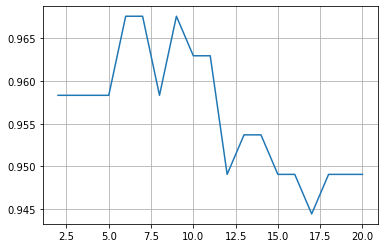

In [219]:
acc=[]
for i in range(2,21):
    model=DecisionTreeClassifier(max_leaf_nodes=i)
    model.fit(X_train_non28_3_ineris,y_train_non28_3_ineris)
    prediction4=model.predict(X_test_non28_3_ineris)
    acc.append(metrics.accuracy_score(prediction4,y_test_non28_3_ineris))
plt.plot(range(2,21), acc)
plt.grid()

In [220]:
DTC_non28_3_ineris=DecisionTreeClassifier(max_leaf_nodes=5)
DTC_non28_3_ineris.fit(X_train_non28_3_ineris,y_train_non28_3_ineris)
prediction4=DTC_non28_3_ineris.predict(X_test_non28_3_ineris)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,y_test_non28_3_ineris))

The accuracy of the Decision Tree is 0.9583333333333334


In [221]:
X_train_non28_3_ineris.columns

Index(['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20',
       'cosine_similarity_40', 'scholle_similarity_40',
       'cosine_similarity_isotopic_mod', 'found_peaks_isotopic'],
      dtype='object')

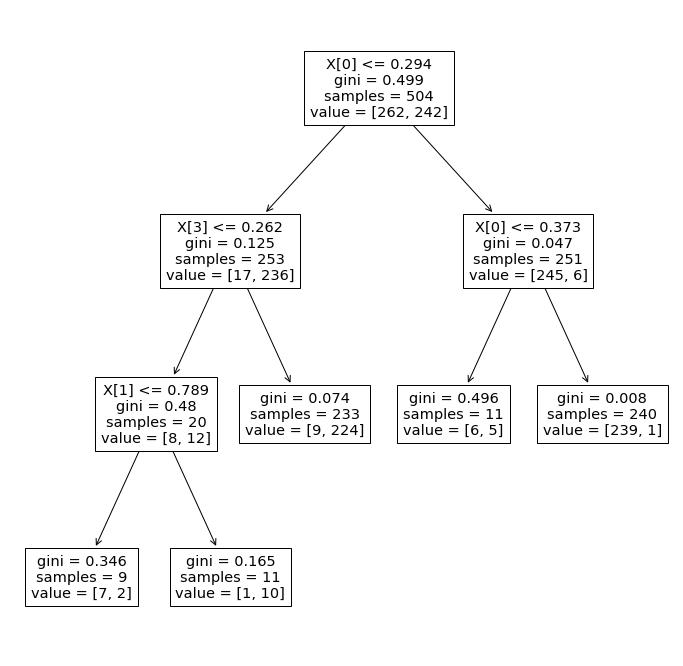

In [222]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12))
_=tree.plot_tree(DTC_non28_3_ineris)

In [447]:
molecules = pd.read_csv('molecules.csv')
df_final_28_name = df_final_28.merge(molecules,on=['id_molecule'], how='left')
df_final_28_name = df_final_28_name[['id_molecule', 'molecule_name', 'retention_time_exp', 'tic', 'rt_diff_abs',
       'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic', 'ancienne_prob_avec_rt', 'ancienne_prob_sans_rt', 'nouvelle_prob_avec_rt',
        'nouvelle_prob_sans_rt']]

In [449]:
df_final_28_name.to_excel('Treboul_allion_pos_new_model.xlsx')

In [445]:
df_final_28.to_excel('Treboul_allion_pos_new_model.xlsx')

In [444]:
df_final_28[df_final_28['id_molecule'].isin([283,1180])]

,id_mzml,id_molecule,retention_time_exp,tic,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,ancienne_prob_avec_rt,ancienne_prob_sans_rt,nouvelle_prob_avec_rt,nouvelle_prob_sans_rt
15047,28,283,7.94095,62656.863281,0.06105,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.68,0.80,0.906095,0.579620
15048,28,283,9.47105,11261.068359,1.46905,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.00,0.16,0.002340,0.186394
16146,28,1180,7.94095,62656.863281,NaN,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.80,0.80,0.579620,0.579620
16147,28,1180,9.47105,11261.068359,NaN,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.16,0.16,0.186394,0.186394


In [452]:
import sklearn
# dir(joblib)
sklearn.__version__

'0.23.2'

In [443]:
X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_28 = pd.read_csv('final.csv')
df_final_28 = df_final_28[df_final_28['id_mzml']==28]
df_final_28['rt_diff']=df_final_28['retention_time_exp']-df_final_28['retention_time']
df_final_28['rt_diff_abs'] = df_final_28['rt_diff'].apply(lambda x : abs(x))
df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp', 'tic']+X1_ret]

df_final_28[X1] = df_final_28[X1].fillna(0)
df_final_28['ancienne_prob_avec_rt'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
df_final_28['ancienne_prob_sans_rt'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3.predict_proba([x[1:]])[0,1] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
df_final_28['nouvelle_prob_avec_rt'] = df_final_28[X1_ret].apply(lambda x: LR_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else LR_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
df_final_28['nouvelle_prob_sans_rt'] = df_final_28[X1_ret].apply(lambda x: LR_non28_3.predict_proba([x[1:]])[0,1] if(np.all(pd.notnull(x[0]))) else LR_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
# df_final_28['class'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict([x])[0] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict([x[1:]])[0], axis = 1)
df_final_28

,id_mzml,id_molecule,retention_time_exp,tic,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,ancienne_prob_avec_rt,ancienne_prob_sans_rt,nouvelle_prob_avec_rt,nouvelle_prob_sans_rt
14806,28,0,5.845100,14800.327148,5.196900,0.373945,0.389976,0.762951,0.685997,0.980761,0,0.16,0.04,3.363016e-12,0.043324
14807,28,0,6.205133,11471.552734,4.836867,0.338911,0.342961,0.768403,0.676759,0.980761,0,0.16,0.04,2.421006e-11,0.039294
14808,28,0,10.949717,10905.550781,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.84,0.10,8.898214e-01,0.404086
14809,28,0,11.489750,12132.080078,0.447750,0.278953,0.234525,0.730511,0.601869,0.980761,0,0.12,0.04,4.255531e-01,0.026721
14810,28,0,11.965500,14352.488281,0.923500,0.263550,0.222453,0.563820,0.537167,0.980761,0,0.08,0.02,3.836642e-02,0.019909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16376,28,1499,8.468133,31032.666016,NaN,0.228611,0.559983,0.331296,0.336332,0.984958,1,0.62,0.62,4.711475e-01,0.471147
16377,28,1502,13.637033,17636.476562,NaN,0.077432,0.094474,0.124269,0.137998,0.167735,1,0.02,0.02,5.674154e-02,0.056742
16378,28,1506,9.612483,13494.677734,NaN,0.014696,0.007022,0.620210,0.586140,0.983259,0,0.02,0.02,1.574012e-02,0.015740
16379,28,1506,10.975433,13353.364258,NaN,0.014696,0.007022,0.349424,0.237950,0.130302,1,0.00,0.00,6.820940e-02,0.068209


In [223]:

# df_final_28 = pd.read_csv('final.csv')
# df_final_28 = df_final_28[df_final_28['id_mzml']==28]
# df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
# df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
# df_final_28 = df_final_28.fillna(0)
# df_final_28['predicted_class_3'] = RFC_non28_3.predict(df_final_28[X1])
# df_final_28['prob_3'] = RFC_non28_3.predict_proba(df_final_28[X1])[:,1:2]



X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_28 = pd.read_csv('final.csv')
df_final_28 = df_final_28[df_final_28['id_mzml']==28]
df_final_28['rt_diff']=df_final_28['retention_time_exp']-df_final_28['retention_time']
df_final_28['rt_diff_abs'] = df_final_28['rt_diff'].apply(lambda x : abs(x))
df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp']+X1_ret]
# df_final_28_ineris = df_final_28[]
# df_final_28
df_final_28[X1] = df_final_28[X1].fillna(0)
df_final_28['prob'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
# df_final_28['class'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict([x])[0] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict([x[1:]])[0], axis = 1)
df_final_28
# df_final_28['predicted_class_3'] = RFC_non28_3.predict(df_final_28[X1])
# df_final_28['prob_3'] = RFC_non28_3.predict_proba(df_final_28[X1])[:,1:2]
# df_final_28['predicted_class_rt'] = RFC_ineris.predict(df_final_28[X1_ret])
# df_final_28['prob_rt'] = RFC_ineris.predict_proba(df_final_28[X1_ret])[:,1:2]

,id_mzml,id_molecule,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob
14806,28,0,5.845100,5.196900,0.373945,0.389976,0.762951,0.685997,0.980761,0,0.04
14807,28,0,6.205133,4.836867,0.338911,0.342961,0.768403,0.676759,0.980761,0,0.00
14808,28,0,10.949717,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.68
14809,28,0,11.489750,0.447750,0.278953,0.234525,0.730511,0.601869,0.980761,0,0.04
14810,28,0,11.965500,0.923500,0.263550,0.222453,0.563820,0.537167,0.980761,0,0.04
...,...,...,...,...,...,...,...,...,...,...,...
16376,28,1499,8.468133,NaN,0.228611,0.559983,0.331296,0.336332,0.984958,1,0.54
16377,28,1502,13.637033,NaN,0.077432,0.094474,0.124269,0.137998,0.167735,1,0.18
16378,28,1506,9.612483,NaN,0.014696,0.007022,0.620210,0.586140,0.983259,0,0.00
16379,28,1506,10.975433,NaN,0.014696,0.007022,0.349424,0.237950,0.130302,1,0.04


In [374]:
df_final_28[(df_final_28['prob_LR']>0.9)&(df_final_28['prob_LR']<=1)].sort_values(by=['prob_LR'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
16340,28,1442,11.309733,NaN,0.853250,0.609377,0.932568,0.959476,0.992530,1,0.82,0.899664
14987,28,224,7.992383,0.067617,0.705544,0.647865,0.792428,0.836990,0.990330,0,0.96,0.899354
14831,28,11,13.187000,0.151000,0.418776,0.511349,0.487789,0.505584,0.994621,1,0.88,0.899313
14912,28,106,12.274083,0.076917,0.631937,0.791657,0.192418,0.232169,0.984203,1,0.40,0.898281
15642,28,689,12.376950,NaN,0.997718,0.978713,0.808710,0.741890,0.993751,1,0.94,0.895761
16351,28,1459,9.059600,NaN,0.961425,0.959946,0.726414,0.791018,0.948481,1,0.98,0.891711
14808,28,0,10.949717,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.68,0.889821
15514,28,584,10.268250,NaN,0.995260,0.965522,0.807647,0.708433,0.999947,1,0.98,0.886367
14843,28,27,8.326683,0.176317,0.481907,0.666220,0.479253,0.452699,0.951300,1,0.68,0.885422
15037,28,271,11.579750,0.196750,1.000000,1.000000,1.000000,1.000000,0.983944,0,0.44,0.883146


In [446]:
# import sklearn.external.joblib as extjoblib
import joblib
joblib.dump(LR_non28_3_ineris, 'LR_non28_3_ineris.pkl') 
joblib.dump(LR_non28_3, 'LR_non28_3.pkl') 
# RFC_non28_3 = joblib.load('RFC_non28_3.pkl')
# RFC_non28_3_ineris = joblib.load('RFC_non28_3_ineris.pkl')

['LR_non28_3.pkl']

In [377]:
molecules = pd.read_csv('molecules.csv')
df_final_28_name = df_final_28.merge(molecules,on=['id_molecule'], how='left')
df_final_28_name = df_final_28_name[['id_molecule', 'molecule_name', 'retention_time_exp', 'rt_diff_abs',
       'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic', 'prob', 'prob_LR']]

In [389]:
df_final_28_name[(df_final_28_name['prob']>0.99)&(df_final_28_name['prob']<=1)].sort_values(by=['prob'], ascending=False)

,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
74,54,Carbamazepine,10.306817,0.070183,0.325348,0.326123,0.662600,0.867468,0.999538,1,1.0,0.949476
86,85,DEHP,14.575667,0.104333,0.999933,0.999916,0.999627,0.999754,0.999803,1,1.0,0.974813
1411,1282,Benzododecinium (Ajatin),20.631767,NaN,0.996866,0.999720,0.838245,0.920009,0.999654,1,1.0,0.935062
1410,1282,Benzododecinium (Ajatin),20.348883,NaN,0.990941,0.999137,0.782219,0.884408,0.999920,1,1.0,0.926609
1327,1150,Telmisartan,11.284017,NaN,0.996073,0.996361,0.872239,0.922566,0.999359,1,1.0,0.936488
1135,978,TCPP / Tri-(2-chloroisopropyl)phosphate,11.399750,NaN,0.908733,0.935872,0.999232,0.999407,0.999554,1,1.0,0.945479
1040,856,Irbesartan,10.113950,NaN,0.957981,0.901886,0.965824,0.980547,0.999893,1,1.0,0.939933
1005,816,Moclobemide,10.319667,NaN,0.994481,0.994666,0.991188,0.992676,0.998279,1,1.0,0.950062
957,782,DEET / Diethyltoluamide,10.975433,NaN,0.992663,0.993274,0.953841,0.965992,0.996987,1,1.0,0.945189
864,711,Diuron,10.821133,NaN,0.989659,0.990382,0.942402,0.972474,0.999133,1,1.0,0.945551


In [399]:
df_final_28_name[df_final_28_name['molecule_name']=='Valsartan'].sort_values(by=['prob'], ascending=False)

,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
241,283,Valsartan,7.94095,0.06105,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.80,0.906095
1340,1180,Valsartan,7.94095,NaN,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.78,0.579620
1341,1180,Valsartan,9.47105,NaN,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.28,0.186394
242,283,Valsartan,9.47105,1.46905,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.00,0.002340


In [407]:
df_final_28_name_excel[df_final_28_name_excel['rt_diff_abs']<0.2]

,Unnamed: 0,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
2,2,0,(E)-Diethylstilbestrol,10.949717,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.68,0.889821
7,7,2,1-Hydroxy-ibuprofene,6.629433,0.186567,0.347278,0.507411,0.438923,0.436474,0.989695,0,0.80,0.686765
8,8,2,1-Hydroxy-ibuprofene,6.925167,0.109167,0.400953,0.539206,0.452992,0.453105,0.989695,0,0.88,0.778342
21,21,10,2-OH-isoproturon,8.815300,0.050300,0.401271,0.363302,0.509816,0.485458,0.093807,1,0.56,0.826790
25,25,11,4-Methylbenzylidene camphor,13.187000,0.151000,0.418776,0.511349,0.487789,0.505584,0.994621,1,0.88,0.899313
29,29,12,Acebutolol,11.746900,0.092900,0.049015,0.023622,0.132324,0.135028,0.978906,0,0.44,0.614973
30,30,13,4-Nonyl phenol diethoxylate,13.405583,0.061417,0.312512,0.085592,0.819382,0.618241,0.978241,0,0.76,0.870120
34,34,25,Anthraquinone,11.206867,0.053133,0.209309,0.379646,0.342501,0.323975,0.995202,1,0.92,0.915504
37,37,27,Atenolol,8.326683,0.176317,0.481907,0.666220,0.479253,0.452699,0.951300,1,0.68,0.885422
42,42,28,Atrazine,11.039717,0.071283,0.503726,0.677199,0.410375,0.512964,0.945673,1,0.80,0.926416


In [405]:
df_final_28_name_excel = pd.read_excel('Treboul_allion_pos_model.xlsx')
df_final_28_name_excel['prob_LR'] = df_final_28_name_excel[X1_ret].apply(lambda x: LR_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else LR_non28_3.predict_proba([x[1:]])[0,1], axis = 1)

In [409]:
df_final_28_name_excel[(df_final_28_name_excel['prob_LR']>0.9)&(df_final_28_name_excel['prob_LR']<=1)].sort_values(by=['prob_LR'], ascending=False)

,Unnamed: 0,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
203,203,252,TCPP / Tri-(2-chloroisopropyl)phosphate,11.399750,0.068250,0.999996,0.999988,0.999421,0.999612,0.999554,1,1.00,0.979263
206,206,257,Telmisartan,11.284017,0.073983,0.999274,0.999324,0.981338,0.989225,0.999359,1,1.00,0.977921
115,115,141,Irbesartan,10.113950,0.061050,0.957981,0.901886,0.965824,0.980547,0.999893,1,1.00,0.977819
130,130,166,Metolachlor,12.119783,0.063217,0.997795,0.998843,0.889003,0.927225,0.999963,1,1.00,0.975544
86,86,85,DEHP,14.575667,0.104333,0.999933,0.999916,0.999627,0.999754,0.999803,1,1.00,0.974813
236,236,276,Tributyl phosphate,12.891267,0.075733,0.921305,0.971284,0.879800,0.953773,0.992450,1,1.00,0.973085
103,103,91,Diclofenac,9.059600,0.073400,0.911702,0.909560,0.757405,0.810207,0.948481,1,0.96,0.963618
246,246,285,Venlafaxine,12.376950,0.099050,0.995953,0.978346,0.799208,0.728710,0.993751,1,1.00,0.963313
226,226,270,TPPA / Triphenyl phosphate,12.582683,0.127317,0.956523,0.991552,0.853456,0.823677,0.999618,1,1.00,0.962341
104,104,98,Di-isodecyl phthalate,15.025683,0.071317,0.806344,0.811685,0.704012,0.619755,0.984605,1,1.00,0.958648


In [423]:
df_final_28_name_excel[df_final_28_name_excel['molecule_name']=='Valsartan'].sort_values(by=['prob'], ascending=False)

,Unnamed: 0,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
241,241,283,Valsartan,7.94095,0.06105,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.80,0.906095
1340,1340,1180,Valsartan,7.94095,NaN,0.753932,0.780709,0.173704,0.346233,0.987604,1,0.78,0.579620
1341,1341,1180,Valsartan,9.47105,NaN,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.28,0.186394
242,242,283,Valsartan,9.47105,1.46905,0.093974,0.100567,0.089300,0.151305,0.987604,1,0.00,0.002340


In [ ]:
df_final_28_name_excel['']

In [428]:
tics[tics.id_molecule==1506]

,id_molecule,retention_time_exp,tic
16378,1506,9.612483,13494.677734
16379,1506,10.975433,13353.364258


In [426]:
df_final_28_name_excel[df_final_28_name_excel.molecule_name=='Phenmedipham']

,Unnamed: 0,id_molecule,molecule_name,retention_time_exp,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
1572,1572,1506,Phenmedipham,9.612483,NaN,0.014696,0.007022,0.620210,0.58614,0.983259,0,0.00,0.015740
1573,1573,1506,Phenmedipham,10.975433,NaN,0.014696,0.007022,0.349424,0.23795,0.130302,1,0.04,0.068209


In [437]:
pd.isna(df_final_28_name_excel_tic['tic']).value_counts()

False    1265
True      310
Name: tic, dtype: int64

In [424]:
df_final_28_name_excel_tic = df_final_28_name_excel.merge(tics,on=['id_molecule', 'retention_time_exp'], how='left')
# df_final_28_name_excel_tic = df_final_28_name_excel_tic[['id_molecule', 'molecule_name', 'retention_time_exp', 'tic', 'rt_diff_abs','cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40', 'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic', 'prob', 'prob_LR']]
df_final_28_name_excel_tic[['id_molecule', 'molecule_name', 'retention_time_exp', 'tic', 'rt_diff_abs',
       'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
       'scholle_similarity_40', 'cosine_similarity_isotopic_mod',
       'found_peaks_isotopic', 'prob', 'prob_LR']]

,id_molecule,molecule_name,retention_time_exp,tic,rt_diff_abs,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,prob,prob_LR
0,0,(E)-Diethylstilbestrol,5.845100,14800.327148,5.196900,0.373945,0.389976,0.762951,0.685997,0.980761,0,0.04,3.363016e-12
1,0,(E)-Diethylstilbestrol,6.205133,11471.552734,4.836867,0.338911,0.342961,0.768403,0.676759,0.980761,0,0.00,2.421006e-11
2,0,(E)-Diethylstilbestrol,10.949717,10905.550781,0.092283,0.295263,0.266111,0.625149,0.573021,0.567769,1,0.68,8.898214e-01
3,0,(E)-Diethylstilbestrol,11.489750,12132.080078,0.447750,0.278953,0.234525,0.730511,0.601869,0.980761,0,0.04,4.255531e-01
4,0,(E)-Diethylstilbestrol,11.965500,14352.488281,0.923500,0.263550,0.222453,0.563820,0.537167,0.980761,0,0.04,3.836642e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,1499,Fluorandrenolone,8.468133,31032.666016,NaN,0.228611,0.559983,0.331296,0.336332,0.984958,1,0.54,4.711475e-01
1571,1502,Simvastatin,13.637033,NaN,NaN,0.077432,0.094474,0.124269,0.137998,0.167735,1,0.18,5.674154e-02
1572,1506,Phenmedipham,9.612483,13494.677734,NaN,0.014696,0.007022,0.620210,0.586140,0.983259,0,0.00,1.574012e-02
1573,1506,Phenmedipham,10.975433,NaN,NaN,0.014696,0.007022,0.349424,0.237950,0.130302,1,0.04,6.820940e-02


In [422]:
X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_28 = pd.read_csv('final.csv')
df_final_28 = df_final_28[df_final_28['id_mzml']==28]
df_final_28['rt_diff']=df_final_28['retention_time_exp']-df_final_28['retention_time']
df_final_28['rt_diff_abs'] = df_final_28['rt_diff'].apply(lambda x : abs(x))
df_final_28['found_peaks_isotopic'] = df_final_28['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_28 = df_final_28[['id_mzml', 'id_molecule', 'retention_time_exp', 'tic']+X1_ret]

# df_final_28[X1] = df_final_28[X1].fillna(0)
# df_final_28['prob'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
# df_final_28['prob_LR'] = df_final_28[X1_ret].apply(lambda x: LR_non28_3_ineris.predict_proba([x])[0,1] if(np.all(pd.notnull(x[0]))) else LR_non28_3.predict_proba([x[1:]])[0,1], axis = 1)
# df_final_28['class'] = df_final_28[X1_ret].apply(lambda x: RFC_non28_3_ineris.predict([x])[0] if(np.all(pd.notnull(x[0]))) else RFC_non28_3.predict([x[1:]])[0], axis = 1)
tics=df_final_28[['id_molecule', 'retention_time_exp', 'tic']]
tics

,id_molecule,retention_time_exp,tic
14806,0,5.845100,14800.327148
14807,0,6.205133,11471.552734
14808,0,10.949717,10905.550781
14809,0,11.489750,12132.080078
14810,0,11.965500,14352.488281
...,...,...,...
16376,1499,8.468133,31032.666016
16377,1502,13.637033,17636.476562
16378,1506,9.612483,13494.677734
16379,1506,10.975433,13353.364258


In [228]:
df_final_28_name.to_excel('Treboul_allion_pos_model.xlsx')

In [229]:
X1_ret = ['rt_diff_abs', 'cosine_similarity_20', 'scholle_similarity_20', 'cosine_similarity_40',
      'scholle_similarity_40', 'cosine_similarity_isotopic_mod', 'found_peaks_isotopic']
df_final_27 = pd.read_csv('final.csv')
df_final_27 = df_final_27[df_final_27['id_mzml']==27]
df_final_27['rt_diff']=df_final_27['retention_time_exp']-df_final_27['retention_time']
df_final_27['rt_diff_abs'] = df_final_27['rt_diff'].apply(lambda x : abs(x))
df_final_27['found_peaks_isotopic'] = df_final_27['num_isotopic_exp_peaks'].apply(lambda x : 0 if x==1 else 1)
df_final_27 = df_final_27[['id_mzml', 'id_molecule', 'retention_time_exp']+X1]
df_final_27 = df_final_27.fillna(0)
df_final_27['predicted_class_3'] = RFC_non28_3.predict(df_final_27[X1])
df_final_27['prob_3'] = RFC_non28_3.predict_proba(df_final_27[X1])[:,1:2]

In [230]:
df_final_27[(df_final_27['prob_3']>-1)&(df_final_27['prob_3']<=0.1)].sort_values(by=['prob_3'], ascending=False)

,id_mzml,id_molecule,retention_time_exp,cosine_similarity_20,scholle_similarity_20,cosine_similarity_40,scholle_similarity_40,cosine_similarity_isotopic_mod,found_peaks_isotopic,predicted_class_3,prob_3
14787,27,1052,8.736534,0.027409,0.007142,0.511265,0.362880,0.992034,1,0,0.1
14774,27,871,8.736534,0.029498,0.007674,0.515445,0.367468,0.992034,1,0,0.1
14788,27,1052,9.507400,0.027409,0.007142,0.511265,0.362880,0.992034,1,0,0.1
14775,27,871,9.507400,0.029498,0.007674,0.515445,0.367468,0.992034,1,0,0.1
14654,27,337,13.640000,0.532016,0.543272,0.746640,0.701663,0.992202,0,0,0.1
...,...,...,...,...,...,...,...,...,...,...,...
14773,27,871,8.136967,0.029498,0.007674,0.515445,0.367468,0.011464,1,0,0.0
14772,27,871,7.194833,0.029498,0.007674,0.515445,0.367468,0.974775,0,0,0.0
14757,27,747,13.511517,0.000000,0.000000,0.000000,0.000000,0.646492,1,0,0.0
14768,27,793,7.858617,0.000000,0.000000,0.053551,0.037373,0.101911,1,0,0.0
